<span style="color: red;">NOTE:  
    Sections marked TODO should be completed before final submission.  
    Delete this section when finished.</span>

# AI Academy Semester 1 Capstone

Last Updated: 2022-07-29  
Collaborators: A. Donahue, C. Lineman, N. Netznik, T.V. Nguyen, A. White

# <span style="color: blue;">Background</span>

<span style='color: red'>TODO</span>  
More specifically point out stakeholders (head of CV)

### Business Case

Original video content is a growing field into which many big businesses are investing. The client, Computing Vision, would like to begin creating their own original videos, so they are creating a new movie studio. They are seeking assistance in understanding the current trends in films, specifically which kinds movies are currently doing the best at the box office. They will use these insights to drive their own choices in movie creation.

### Scope

This study will use a variety of historic data on recent movie performance to illuminate trends in profitability and to develop actionable insights for the head of Computing Vision's new movie studio. We will limit data to the range of 2010-present (where available) to ensure that insights are still valid.

### Purpose

The results of this study will provide statistical support for at least three actionable insights that Computing Vision can use to **maximize profits and performance** from their new movie studio.

# <span style="color: blue;">Importing and Processing Data Sources</span>

In [215]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import zipfile
import scipy.stats as st
import math

<span style='color: red'>TODO</span>  
Alex W.: Import and suppress warnings

In [216]:
#read data
movie_gross = pd.read_csv('zippedData/bom.movie_gross.csv.gz')
movie_info = pd.read_csv('zippedData/rt.movie_info.tsv.gz', sep='\t')
reviews = pd.read_csv('zippedData/rt.reviews.tsv.gz', sep='\t', encoding='ANSI')
movies = pd.read_csv('zippedData/tmdb.movies.csv.gz')
movie_budgets = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')

zip_file = "zippedData/im.db.zip"
try:
    with zipfile.ZipFile(zip_file, 'r') as z:
        z.extractall("zippedData/unZipped/")
        print("Extracted all")
except:
    print("Invalid file")

conn = sqlite3.connect("zippedData/unZipped/im.db")

Extracted all


### Data Sources

Our team has thoroughly reviewed 5 different sources of data in which we were able to pull detailed insights that will help lead Computing Vision to success in the movie creation realm. 

#### Sources

* Box Office Mojo(https://www.boxofficemojo.com/)
* IMDB (https://www.imdb.com/)
* Rotten Tomatoes (https://www.rottentomatoes.com/)
* TheMovieDB (https://www.themoviedb.org/)
* The Numbers (https://www.the-numbers.com/)

#### Box Office Mojo

Our team imported Data from Box Office Mojo as we found that it to be a credible resource that provided with a large amount of data and information regarding movie gross values. We successfully pulled and sized the data to present us with a data frame of 3387 movies including the movie title, the studio of production, the domestic and foreign gross values of each movie, and the year the movie was released as well. 



#### IMDB

Internet Movie Database (IMDb) is considered the largest and most comprehensive movie databases. This database provides information related to films, television series, home videos, video games, and streaming content. Our team found this source to be a valuable as it allowed us to view a large depository of movies specific information. This source allowed us to pull a wide arrange of data and source into different tables that includes information on movie personal, principals, directors, writer, rating, basics, etc.

#### Rotten Tomatoes 

Rotten Tomatoes is a review aggregation website for film and television. Rotten Tomatoes is one of the most trusted recommendations recourses for quality of entertainment. Rotten tomatoes specify in reviews from critics and provides a comprehensive guide on ratings for movies. We were able to use this source to specify the relation of Rotten Tomatoes rating and movies success. As well link these rating to several different aspects in which we give insights on throughout the analysis. This source was able to provide was with multiple different data frames in which our team use primarily in two which include data on Movie reviews and Movie specific information.  Regarding movie information we were successfully able to pull data on 1560 movies with details regarding synopsis, MPA Rating (PG, PG13, R, etc.), genre, director, writer, Theater date, DVD release date, currency, Box office sales, movie runtime, and production studio.  

As well with the use of Rotten tomatoes source we were able to import a data frame allowing us to view details on movie reviews. We were able to import 54432 data points that gave us compressive information regarding movie ID, distinct reviews, review rating, fresh/rotten specification, critic of the review, the top critic, publisher, and date of review. We must note that this data frame provided was with multiple reviews from different critics through different publishers on different dates for the movies. 


#### The MovieDB 

The Movie Database (TMDB) is a community-built movie and TV database. This data base was able to provide us insights on individual movie specifics and there rating.  We were able to successfully import 26517 movies with information regarding genre, language, title, popularity, release date, vote average and vote count regarding movie rating. 

#### The Numbers

The Numbers is a film industry data website that tracks box office revenue.  We primarily used this source to generate a data frame that provided information regarding movie budgets. Digging deeper we were able to pull information for 5782 movies with details on Release date, Movie title, production budget, domestic gross, and worldwide gross. Our team found this provided data to valuable in regards of generating profit percentage and movie success throughout our overall analysis. 

#### Limitations  

We must also note that our team did run into some limitations when it came to connecting and merging data frames due to differentiation in primary keys. Our team found that the best fit primary key to over come this issue was merging and connecting through movie titles. 

The specific limitation with the use of titles is that they could potentially be less consistent than numeric identifiers.

# <span style="color: blue;">Data Preparation</span>

## Movie Gross

In [217]:
movie_gross.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [218]:
movie_gross.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


Here we will be converting numeric strings to floats. 

In [219]:
# Turn foreign gross to an int
movie_gross['foreign_gross'] = movie_gross['foreign_gross'].str.replace(',','')
movie_gross['foreign_gross'] = movie_gross["foreign_gross"].astype("float64")

## Movie Info

In [220]:
movie_info.head()

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200 minutes,NaN


In [221]:
movie_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1560 non-null   int64 
 1   synopsis      1498 non-null   object
 2   rating        1557 non-null   object
 3   genre         1552 non-null   object
 4   director      1361 non-null   object
 5   writer        1111 non-null   object
 6   theater_date  1201 non-null   object
 7   dvd_date      1201 non-null   object
 8   currency      340 non-null    object
 9   box_office    340 non-null    object
 10  runtime       1530 non-null   object
 11  studio        494 non-null    object
dtypes: int64(1), object(11)
memory usage: 146.4+ KB


Here again we observed that some numeric values were stored as strings. So we adjusted them apropriately to floats. 
As well adjusted curency to a boolean so that it will be easier to operate on in the future. 

In [222]:
# Turned run time into an integer
movie_info['runtime'] = movie_info['runtime'].str.replace(' minutes','')
movie_info['runtime']  = movie_info['runtime'].astype("float64")

# Turned box_offices into an interger
movie_info['box_office'] = movie_info['box_office'].str.replace(',','')
movie_info['box_office'] = movie_info['box_office'].astype("float64")

# Change currency to binary variable
for i in movie_info['currency']:
    if i is not None:
        i = 1
    else:
        i = 0

## Reviews

In [223]:
reviews.head()

,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"
2,3,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018"
3,3,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017"
4,3,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017"


In [224]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54432 entries, 0 to 54431
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          54432 non-null  int64 
 1   review      48869 non-null  object
 2   rating      40915 non-null  object
 3   fresh       54432 non-null  object
 4   critic      51710 non-null  object
 5   top_critic  54432 non-null  int64 
 6   publisher   54123 non-null  object
 7   date        54432 non-null  object
dtypes: int64(2), object(6)
memory usage: 3.3+ MB


In [225]:
# Update 'fresh'/'rotten' in reviews to boolean variable
reviews['fresh'] = reviews['fresh'].str.replace('fresh','1')
reviews['fresh'] = reviews['fresh'].str.replace('rotten','0')
reviews['fresh']  = reviews['fresh'].astype("float64")

reviews.drop_duplicates(inplace=True)

A brief analysis reveals that ratings within the Rotten Tomatoes reviews database are very inconsistent. We seek to clean and reorganize these ratings to make them usable.

In [226]:
reviews['rating'].unique()

array(['3/5', nan, 'C', '2/5', 'B-', '2/4', 'B', '3/4', '4/5', '4/4',
       '6/10', '1/4', '8', '2.5/4', '4/10', '2.0/5', '3/10', '7/10', 'A-',
       '5/5', 'F', '3.5/4', 'D+', '1.5/4', '3.5/5', '8/10', 'B+', '9/10',
       '2.5/5', '7.5/10', '5.5/10', 'C-', '1.5/5', '1/5', '5/10', 'C+',
       '0/5', '6', '0.5/4', 'D', '3.1/5', '3/6', '4.5/5', '0/4', '2/10',
       'D-', '7', '1/10', '3', 'A+', 'A', '4.0/4', '9.5/10', '2.5',
       '2.1/2', '6.5/10', '3.7/5', '8.4/10', '9', '1', '7.2/10', '2.2/5',
       '0.5/10', '5', '0', '2', '4.5', '7.7', '5.0/5', '8.5/10', '3.0/5',
       '0.5/5', '1.5/10', '3.0/4', '2.3/10', '4.5/10', '4/6', '3.5',
       '8.6/10', '6/8', '2.0/4', '2.7', '4.2/10', '5.8', '4', '7.1/10',
       '5/4', 'N', '3.5/10', '5.8/10', 'R', '4.0/5', '0/10', '5.0/10',
       '5.9/10', '2.4/5', '1.9/5', '4.9', '7.4/10', '1.5', '2.3/4',
       '8.8/10', '4.0/10', '2.2', '3.8/10', '6.8/10', '7.3', '7.0/10',
       '3.2', '4.2', '8.4', '5.5/5', '6.3/10', '7.6/10', '8.1/10',
  

We will make the following modifications to the ratings column:

* We will be changing all letter "grades" to numerical scores out of 10, evenly distributed between 0 and 10.
    * Note that F+ and F- will be grouped with F.
* We will be replacing all NaN ratings, ratings out of 2, all ratings without an "out-of" denominator, and any other nonsensical ratings with '-1/1'. This will allow us to split all ratings by the '/' character before making further calculations in the future; upon performing these calculations we will go back and reset all '-1/1' values to NaN.

In [227]:
# Change letter ratings to numerical (out of 10)
reviews['rating'].replace('F+', 'F', inplace=True)
reviews['rating'].replace('F-', 'F', inplace=True)

letter_ratings = ['A+','A','A-','B+','B','B-','C+','C','C-','D+','D','D-','F']
nums = list(np.round(np.linspace(0,10, 13), 1))
num_ratings = [f'{str(num)}/10' for num in nums]
mapping = dict(zip(letter_ratings, num_ratings))

for rating in letter_ratings:
    reviews.replace(rating, mapping[rating], inplace=True)

reviews['rating'].fillna('-1/1', inplace=True)
    
# Remove all ratings that do not contain '/'
for rating in reviews['rating'].unique():
    if "/" not in rating:
        reviews['rating'].replace(rating, '-1/1', inplace=True)

# Remove other nonsensical ratings
reviews['rating'].replace('R', '-1/1', inplace=True)
reviews['rating'].replace('N', '-1/1', inplace=True)
reviews['rating'].replace('T', '-1/1', inplace=True)

reviews['rating'].replace('1/2', '-1/1', inplace=True)
reviews['rating'].replace('2/2', '-1/1', inplace=True)
reviews['rating'].replace('3/2', '-1/1', inplace=True)
reviews['rating'].replace('3 1/2', '-1/1', inplace=True)
reviews['rating'].replace('1-5', '-1/1', inplace=True)
reviews['rating'].replace('5/4', '-1/1', inplace=True)
reviews['rating'].replace('2.1/2', '-1/1', inplace=True)
reviews['rating'].replace('5.5/5', '-1/1', inplace=True)

In [228]:
reviews['rating'].unique()

array(['3/5', '-1/1', '5.8/10', '2/5', '4.2/10', '2/4', '3.3/10', '3/4',
       '4/5', '4/4', '6/10', '1/4', '2.5/4', '4/10', '2.0/5', '3/10',
       '7/10', '1.7/10', '5/5', '10.0/10', '3.5/4', '7.5/10', '1.5/4',
       '3.5/5', '8/10', '2.5/10', '9/10', '2.5/5', '5.5/10', '6.7/10',
       '1.5/5', '1/5', '5/10', '5.0/10', '0/5', '0.5/4', '8.3/10',
       '3.1/5', '3/6', '4.5/5', '0/4', '2/10', '9.2/10', '1/10', '0.0/10',
       '0.8/10', '4.0/4', '9.5/10', '6.5/10', '3.7/5', '8.4/10', '7.2/10',
       '2.2/5', '0.5/10', '5.0/5', '8.5/10', '3.0/5', '0.5/5', '1.5/10',
       '3.0/4', '2.3/10', '4.5/10', '4/6', '8.6/10', '6/8', '2.0/4',
       '7.1/10', '3.5/10', '4.0/5', '0/10', '5.9/10', '2.4/5', '1.9/5',
       '7.4/10', '2.3/4', '8.8/10', '4.0/10', '3.8/10', '6.8/10',
       '7.0/10', '6.3/10', '7.6/10', '8.1/10', '3.6/5', '2/6', '7.7/10',
       '8.9/10', '8.2/10', '2.6/6', '4.1/10', '6.0/10', '1.0/4', '7.9/10',
       '8.7/10', '4.3/10', '9.6/10', '9.0/10', '8.0/10', '6.2/10', '1/

## Movie Budgets

In [229]:
movie_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [230]:
movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


Like above we are again converting strings to floats.

In [231]:
# Remove unwanted symbols from string values and cast string values as floats

movie_budgets['production_budget'] = movie_budgets['production_budget'].str.replace(',','')
movie_budgets['production_budget'] = movie_budgets['production_budget'].str.replace('$', '')
movie_budgets['production_budget'] = movie_budgets['production_budget'].astype("float64")

movie_budgets['domestic_gross'] = movie_budgets['domestic_gross'].str.replace(',','')
movie_budgets['domestic_gross'] = movie_budgets['domestic_gross'].str.replace('$', '')
movie_budgets['domestic_gross'] = movie_budgets['domestic_gross'].astype("float64")

movie_budgets['worldwide_gross'] = movie_budgets['worldwide_gross'].str.replace(',','')
movie_budgets['worldwide_gross'] = movie_budgets['worldwide_gross'].str.replace('$', '')
movie_budgets['worldwide_gross'] = movie_budgets['worldwide_gross'].astype("float64")

movie_budgets['release_date'] = pd.to_datetime(movie_budgets['release_date'])

This will clean the movie titles to that they are uniform to every dataframe.

In [232]:
movie_budgets['movie'] = movie_budgets['movie'].str.replace("â€™", "'")

In [233]:
movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 5782 non-null   int64         
 1   release_date       5782 non-null   datetime64[ns]
 2   movie              5782 non-null   object        
 3   production_budget  5782 non-null   float64       
 4   domestic_gross     5782 non-null   float64       
 5   worldwide_gross    5782 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 271.2+ KB


## Additional Cleaning

Clean all titles to make them consistent over the various dataframes.

In [234]:
# Clean titles to make them consistent/comparable

movie_gross['title'] = movie_gross['title'].str.strip().str.replace('[^\w\s]', '')
movies['original_title'] = movies['original_title'].str.strip().str.replace('[^\w\s]', '')
movie_budgets['movie'] = movie_budgets['movie'].str.replace("â€™", "'") # replaces improperly encoded ' characters
movie_budgets['movie'] = movie_budgets['movie'].str.strip().str.replace('[^\w\s]', '')

movie_gross['title'] = movie_gross['title'].str.upper()
movies['original_title'] = movies['original_title'].str.upper()
movie_budgets['movie'] = movie_budgets['movie'].str.upper()


# <span style="color: blue;">Analysis of Selected Variables</span>

## Budget vs. Profit Ratio

<span style="color: red;">TODO</span>  
Add justification and explanation

The approach looking into Budget and Profit Ratio is see if that if lower budget movies return a higher rate of profit than a higher budget movie. We use profit ratio becasue it takes inflation into account and a better analysis of how much money you are making per what you are putting in. This information can help the business find out how to get more value for their dollars. 

In [235]:
#Setting up a total profit 
movie_budgets["profit"] = movie_budgets['worldwide_gross'] - movie_budgets['production_budget']

In [236]:
grossJoinBudget.groupby(['year', 'budget_type']).sum()

domestic_gross_x  foreign_gross    id  production_budget  \
year budget_type                                                             
2010 high             7.657482e+09   1.002854e+10  5111       6.997500e+09   
     low              1.180547e+09   1.252711e+09  3919       7.927076e+08   
2011 high             7.708415e+09   1.175730e+10  5909       7.083600e+09   
     low              9.158200e+08   8.017220e+08  3355       4.997750e+08   
2012 high             7.869844e+09   1.225122e+10  4804       6.543700e+09   
     low              1.115535e+09   7.553670e+08  3084       4.957150e+08   
2013 high             8.400309e+09   1.277225e+10  4246       7.042000e+09   
     low              1.159735e+09   9.276317e+08  2942       4.830000e+08   
2014 high             7.458404e+09   1.242182e+10  3522       5.711200e+09   
     low              1.300516e+09   1.206495e+09  3177       4.817074e+08   
2015 high             7.685484e+09   1.089130e+10  3896       6.226100e+09   
     low              1.103079e+09   7.631980e+08  3509       5.464000e+08   
2016 high             8.302480e+09   1.301670e+10  4349       6.587500e+09   
     low              1.114447e+09   1.048678e+09  3002       5.652000e+08   
2017 high             7.149700e+09   1.233860e+10  4098       6.029200e+09   
     low              1.004483e+09   1.011522e+09  1850       2.773000e+08   
2018 high             7.394991e+09   1.071158e+10  3765       5.123900e+09   
     low              9.062310e+08   6.935360e+08  1752       2.892000e+08   

                  domestic_gross_y  worldwide_gross        profit  \
year budget_type                                                    
2010 high             7.752552e+09     1.783395e+10  1.083645e+10   
     low              1.096203e+09     2.264076e+09  1.471369e+09   
2011 high             7.800371e+09     1.962946e+10  1.254586e+10   
     low              8.514668e+08     1.626788e+09  1.127013e+09   
2012 high             7.856201e+09     2.032877e+10  1.378507e+10   
     low              1.115102e+09     2.043768e+09  1.548053e+09   
2013 high             8.402349e+09     2.102547e+10  1.398347e+10   
     low              1.108550e+09     2.157684e+09  1.674684e+09   
2014 high             7.456062e+09     1.971098e+10  1.399978e+10   
     low              1.266343e+09     2.529068e+09  2.047361e+09   
2015 high             7.798039e+09     2.081697e+10  1.459087e+10   
     low              1.103803e+09     2.074491e+09  1.528091e+09   
2016 high             8.339382e+09     2.122383e+10  1.463633e+10   
     low              1.113340e+09     2.352843e+09  1.787643e+09   
2017 high             7.148611e+09     2.033088e+10  1.430168e+10   
     low              1.001911e+09     2.060701e+09  1.783401e+09   
2018 high             7.400958e+09     1.938144e+10  1.425754e+10   
     low              9.060950e+08     1.630895e+09  1.341695e+09   

                  release_month  release_year  Season  profitRatio  
year budget_type                                                    
2010 high                   729        205035     265    55.496973  
     low                    625        180874     217   173.501730  
2011 high                   740        225245     271    75.362574  
     low                    452        130668     149   154.929994  
2012 high                   622        185079     238    90.888429  
     low                    422        122731     149   314.607638  
2013 high                   642        177144     234    85.894544  
     low                    387        114742     138   223.292427  
2014 high                   521        155079     198    97.778016  
     low                    435        122827     149   188.088145  
2015 high                   598        171236     210    90.672077  
     low                    412        126947     161   616.840014  
2016 high                   557        171345     225   102.453399  
     low                    401        12

In [237]:
# Set up and merge of two dataframes 
movie_budgets.rename(columns = {'movie' : 'title'}, inplace = True)

grossJoinBudget = pd.DataFrame.merge(movie_gross, movie_budgets, on = 'title')

In [238]:
movie_budgets.sort_values(['profit'], ascending=False)

,id,release_date,title,production_budget,domestic_gross,worldwide_gross,profit
0,1,2009-12-18,AVATAR,425000000.0,760507625.0,2.776345e+09,2.351345e+09
42,43,1997-12-19,TITANIC,200000000.0,659363944.0,2.208208e+09,2.008208e+09
6,7,2018-04-27,AVENGERS INFINITY WAR,300000000.0,678815482.0,2.048134e+09,1.748134e+09
5,6,2015-12-18,STAR WARS EP VII THE FORCE AWAKENS,306000000.0,936662225.0,2.053311e+09,1.747311e+09
33,34,2015-06-12,JURASSIC WORLD,215000000.0,652270625.0,1.648855e+09,1.433855e+09
...,...,...,...,...,...,...,...
352,53,2001-04-27,TOWN COUNTRY,105000000.0,6712451.0,1.036477e+07,-9.463523e+07
341,42,2019-06-14,MEN IN BLACK INTERNATIONAL,110000000.0,3100000.0,3.100000e+06,-1.069000e+08
193,94,2011-03-11,MARS NEEDS MOMS,150000000.0,21392758.0,3.954976e+07,-1.104502e+08
194,95,2020-12-31,MOONFALL,150000000.0,0.0,0.000000e+00,-1.500000e+08


In [239]:
# Filling the nulls with 0 because if there is no value in a forgien or domestic market, then it is assumed that there 
# was not box office sales in that region.
grossJoinBudget.fillna(0, inplace=True)

<span style='color: red'>TODO</span>  
Explain justification for 2 million cutoff point

We choose a 2 million dollar cut off because according to Stephen film study, the average low budget movie budget is around 2 million dollars. For more information you can use the following link: https://stephenfollows.com/average-budget-low-micro-budget-film/


In [240]:
#creating a profit ratio and grouping the data into high and low budget movies
grossJoinBudget['budget_type'] = grossJoinBudget['production_budget'].map(lambda x: 'high' if x >= 20000000  else 'low' )
grossJoinBudget['profitRatio'] = (grossJoinBudget['profit'] - grossJoinBudget['production_budget']) / grossJoinBudget['production_budget']

In [380]:
#removing outliears
Q1 = grossJoinBudget['profitRatio'].quantile(0.25)
Q3 = grossJoinBudget['profitRatio'].quantile(0.75)
IQR = Q3 - Q1

grouped_trimmed = grossJoinBudget.loc[(grossJoinBudget['profitRatio'] >= Q1-1.5*IQR) & (grossJoinBudget['profitRatio'] <= Q3 + 1.5*IQR)]

HighProfitRatioSample = grouped_trimmed.loc[(grossJoinBudget['budget_type'] == 'high')]['profitRatio']
LowProfitRatioSample = grouped_trimmed.loc[(grossJoinBudget['budget_type'] == 'low')]['profitRatio']
grossJoinBudget['profitRatio'] = grouped_trimmed['profitRatio']

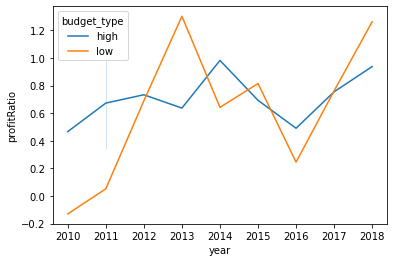

In [381]:
sns.lineplot(x='year', y='profitRatio', hue='budget_type', data=grossJoinBudget);

#### Hypothesis test for budget vs profit ratios  
<span style='color: red'>TODO</span>  Revise hypothesis testing code/markdown to one-tailed test

We will conduct a one-tailed two sample t-test with a 5% level of significance to conclude whether low budget movies yield higher product ratios on average than high budget movies.

    Null: There is no difference in profit ratios between high and low budget movies.
    Alternative: Low budget movies yield higher product ratios on average than high budget movies.

<span style='color: red'>TODO</span>  
Colton: Change code to use earlier column

In [243]:
high = grossJoinBudget.loc[(grossJoinBudget['budget_type'] == 'high')]
low = grossJoinBudget.loc[(grossJoinBudget['budget_type'] == 'low')]


In [244]:
HighProfitRatioSample = high['profitRatio']
LowProfitRatioSample = low['profitRatio']

In [245]:
LowProfitRatioSample

11       9.351945
12      23.482055
35      57.170677
47       5.866781
48       9.751126
          ...    
1301    -1.391090
1302    -1.258991
1304    -1.762057
1305    -1.693122
1306    -1.565610
Name: profitRatio, Length: 522, dtype: float64

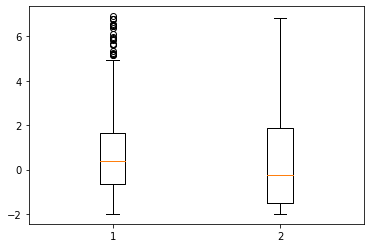

In [382]:
#Shows the need to remove outliears
plt.boxplot([HighProfitRatioSample, LowProfitRatioSample]);

<span style='color: red'>TODO</span>  
Colton: Consider changing to IQR formula; move removing of outliers to earlier in section

In [383]:
stat, pval = st.ttest_ind(HighProfitRatioSample,LowProfitRatioSample,equal_var = False)
pval/2

0.08834875785063458

**Conclusion:** We would reject the NULL  
<span style="color: red;">TODO</span>  
What does it mean? Include business recommendation.

## Genre vs. Profit Ratio

We want to take a look at how the major genres perform around the world relative to their global average performance to determine which genres are the most profitable.

In [252]:
q1= """
SELECT * 
FROM movie_basics
INNER JOIN movie_ratings
USING("movie_id")
INNER JOIN movie_akas
USING("movie_id")



"""
sql_dataset_merge1 = pd.read_sql(q1,conn)
sql_dataset_merge1['title'] = sql_dataset_merge1['title'].str.upper()

In [253]:
sql_dataset_merge1

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,ordering,title,region,language,types,attributes,is_original_title
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,1,SANGHARSH,IN,hi,None,alternative transliteration,0.0
1,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,2,SUNGHURSH,None,None,original,None,1.0
2,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,3,SUNGHURSH,IN,None,None,None,0.0
3,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,4,SUNGHURSH,IN,hi,None,alternative transliteration,0.0
4,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,5,SUNGHARSH,IN,hi,None,alternative spelling,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261801,tt9905462,Pengalila,Pengalila,2019,111.0,Drama,8.4,600,2,SISTERLEAF,IN,en,None,literal English title,0.0
261802,tt9905462,Pengalila,Pengalila,2019,111.0,Drama,8.4,600,3,PENGALILA,IN,None,None,None,0.0
261803,tt9911774,Padmavyuhathile Abhimanyu,Padmavyuhathile Abhimanyu,2019,130.0,Drama,8.4,365,1,PADMAVYUHATHILE ABHIMANYU,None,None,original,None,1.0
261804,tt9911774,Padmavyuhathile Abhimanyu,Padmavyuhathile Abhimanyu,2019,130.0,Drama,8.4,365,2,PATHMAVYUHATHILE ABHIMANYU,IN,ml,None,alternative spelling,0.0


<span style='color: red'>TODO</span>  
Van: Do we need to show the tables every time?

In [254]:
movie_budgets

,id,release_date,title,production_budget,domestic_gross,worldwide_gross,profit
0,1,2009-12-18,AVATAR,425000000.0,760507625.0,2.776345e+09,2.351345e+09
1,2,2011-05-20,PIRATES OF THE CARIBBEAN ON STRANGER TIDES,410600000.0,241063875.0,1.045664e+09,6.350639e+08
2,3,2019-06-07,DARK PHOENIX,350000000.0,42762350.0,1.497624e+08,-2.002376e+08
3,4,2015-05-01,AVENGERS AGE OF ULTRON,330600000.0,459005868.0,1.403014e+09,1.072414e+09
4,5,2017-12-15,STAR WARS EP VIII THE LAST JEDI,317000000.0,620181382.0,1.316722e+09,9.997217e+08
...,...,...,...,...,...,...,...
5777,78,2018-12-31,RED 11,7000.0,0.0,0.000000e+00,-7.000000e+03
5778,79,1999-04-02,FOLLOWING,6000.0,48482.0,2.404950e+05,2.344950e+05
5779,80,2005-07-13,RETURN TO THE LAND OF WONDERS,5000.0,1338.0,1.338000e+03,-3.662000e+03
5780,81,2015-09-29,A PLAGUE SO PLEASANT,1400.0,0.0,0.000000e+00,-1.400000e+03


In [255]:
#keep only original movie
sql_dataset_merge1= sql_dataset_merge1[sql_dataset_merge1.is_original_title==1]

In [256]:
data= movie_budgets.merge(sql_dataset_merge1, how= 'inner', left_on='title', right_on= 'title')
data

,id,release_date,title,production_budget,domestic_gross,worldwide_gross,profit,movie_id,primary_title,original_title,...,runtime_minutes,genres,averagerating,numvotes,ordering,region,language,types,attributes,is_original_title
0,3,2019-06-07,DARK PHOENIX,350000000.0,42762350.0,1.497624e+08,-200237650.0,tt6565702,Dark Phoenix,Dark Phoenix,...,113.0,"Action,Adventure,Sci-Fi",6.0,24451,5,None,None,original,None,1.0
1,9,2017-11-17,JUSTICE LEAGUE,300000000.0,229024295.0,6.559452e+08,355945209.0,tt0974015,Justice League,Justice League,...,120.0,"Action,Adventure,Fantasy",6.5,329135,24,None,None,original,None,1.0
2,10,2015-11-06,SPECTRE,300000000.0,200074175.0,8.796209e+08,579620923.0,tt2379713,Spectre,Spectre,...,148.0,"Action,Adventure,Thriller",6.8,352504,6,None,None,original,None,1.0
3,11,2012-07-20,THE DARK KNIGHT RISES,275000000.0,448139099.0,1.084439e+09,809439099.0,tt1345836,The Dark Knight Rises,The Dark Knight Rises,...,164.0,"Action,Thriller",8.4,1387769,20,None,None,original,None,1.0
4,13,2013-07-02,THE LONE RANGER,275000000.0,89302115.0,2.600021e+08,-14997885.0,tt1210819,The Lone Ranger,The Lone Ranger,...,150.0,"Action,Adventure,Western",6.4,208827,29,None,None,original,None,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1906,56,2013-01-04,ALL SUPERHEROES MUST DIE,20000.0,0.0,0.000000e+00,-20000.0,tt1836212,All Superheroes Must Die,All Superheroes Must Die,...,78.0,"Sci-Fi,Thriller",4.0,1977,6,None,None,original,None,1.0
1907,59,2011-11-25,THE RIDGES,17300.0,0.0,0.000000e+00,-17300.0,tt1781935,The Ridges,The Ridges,...,89.0,"Drama,Horror,Thriller",2.9,127,9,None,None,original,None,1.0
1908,62,2014-12-31,STORIES OF OUR LIVES,15000.0,0.0,0.000000e+00,-15000.0,tt3973612,Stories of Our Lives,Stories of Our Lives,...,60.0,Drama,7.5,85,2,None,None,original,None,1.0
1909,73,2012-01-13,NEWLYWEDS,9000.0,4584.0,4.584000e+03,-4416.0,tt1880418,Newlyweds,Newlyweds,...,95.0,"Comedy,Drama",6.4,1436,2,None,None,original,None,1.0


In [257]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1911 entries, 0 to 1910
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 1911 non-null   int64         
 1   release_date       1911 non-null   datetime64[ns]
 2   title              1911 non-null   object        
 3   production_budget  1911 non-null   float64       
 4   domestic_gross     1911 non-null   float64       
 5   worldwide_gross    1911 non-null   float64       
 6   profit             1911 non-null   float64       
 7   movie_id           1911 non-null   object        
 8   primary_title      1911 non-null   object        
 9   original_title     1911 non-null   object        
 10  start_year         1911 non-null   int64         
 11  runtime_minutes    1898 non-null   float64       
 12  genres             1909 non-null   object        
 13  averagerating      1911 non-null   float64       
 14  numvotes

In [258]:
dataset= data[[ 'release_date', 'title', 'production_budget',
       'domestic_gross', 'worldwide_gross',
       'start_year',
       'runtime_minutes', 'genres', 'averagerating', 'numvotes', 'ordering']]



<span style='color: red'>TODO</span>  
Van: Justify dropping data

In [259]:
dataset=dataset.dropna()
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1896 entries, 0 to 1910
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   release_date       1896 non-null   datetime64[ns]
 1   title              1896 non-null   object        
 2   production_budget  1896 non-null   float64       
 3   domestic_gross     1896 non-null   float64       
 4   worldwide_gross    1896 non-null   float64       
 5   start_year         1896 non-null   int64         
 6   runtime_minutes    1896 non-null   float64       
 7   genres             1896 non-null   object        
 8   averagerating      1896 non-null   float64       
 9   numvotes           1896 non-null   int64         
 10  ordering           1896 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(3), object(2)
memory usage: 177.8+ KB


In [260]:
## calulate profit by subtracting gross and budget and foreign gross by subtracting gross and budget domestic_gross
dataset['profit']= dataset['worldwide_gross']- dataset['production_budget']
dataset['foreign_gross']= dataset['worldwide_gross']- dataset['domestic_gross']
# dataset.loc[dataset['profit'] < 0, 'profit']= 0
##calulate profit ratio
dataset['profit_ratio'] = (dataset['profit'] - dataset['production_budget']) / dataset['production_budget']
## top 5 greatest profit ratio 
dataset.sort_values(['profit_ratio'], ascending=False).head()

,release_date,title,production_budget,domestic_gross,worldwide_gross,start_year,runtime_minutes,genres,averagerating,numvotes,ordering,profit,foreign_gross,profit_ratio
1885,2015-07-10,THE GALLOWS,100000.0,22764410.0,41656474.0,2015,81.0,"Horror,Mystery,Thriller",4.2,17763,15,41556474.0,18892064.0,414.564740
1801,1942-08-13,BAMBI,858000.0,102797000.0,268000000.0,2013,58.0,"Biography,Documentary",7.0,101,2,267142000.0,165203000.0,310.354312
1504,1968-10-01,NIGHT OF THE LIVING DEAD,114000.0,12087064.0,30087064.0,2014,79.0,Horror,5.3,277,1,29973064.0,18000000.0,261.921614
1036,1978-10-17,HALLOWEEN,325000.0,47000000.0,70000000.0,2018,106.0,"Horror,Thriller",6.6,88395,11,69675000.0,23000000.0,213.384615
1759,2012-01-06,THE DEVIL INSIDE,1000000.0,53262945.0,101759490.0,2012,83.0,Horror,4.2,33522,14,100759490.0,48496545.0,99.759490


I want to split up the genres column cells so we can tally each genre individually. Next I'll remove the 'genres' column (with multiple values) and replace it with a 'genre' column (with single values). Then I'll make sure that there is a new row for each genre, so there will be multiple rows with the same movie_title.


In [261]:
df_split_genre = dataset.copy()
split_genre = df_split_genre['genres'].str.split(',').apply(pd.Series, 1).stack().reset_index(level=1, drop=True)
split_genre.name = 'genre_split'
df_split_genre = df_split_genre.drop(['genres'], axis=1).join(split_genre)

# limit data to 2010-present
df_split_genre = df_split_genre.loc[df_split_genre['release_date'].dt.year >= 2010]

In [262]:
df_split_genre.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4154 entries, 0 to 1910
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   release_date       4154 non-null   datetime64[ns]
 1   title              4154 non-null   object        
 2   production_budget  4154 non-null   float64       
 3   domestic_gross     4154 non-null   float64       
 4   worldwide_gross    4154 non-null   float64       
 5   start_year         4154 non-null   int64         
 6   runtime_minutes    4154 non-null   float64       
 7   averagerating      4154 non-null   float64       
 8   numvotes           4154 non-null   int64         
 9   ordering           4154 non-null   int64         
 10  profit             4154 non-null   float64       
 11  foreign_gross      4154 non-null   float64       
 12  profit_ratio       4154 non-null   float64       
 13  genre_split        4154 non-null   object        
dtypes: datet

In [263]:
df_split_genre['genre_split'].unique()


array(['Action', 'Adventure', 'Sci-Fi', 'Fantasy', 'Thriller', 'Western',
       'Animation', 'Comedy', 'Crime', 'Drama', 'Family', 'Horror',
       'Romance', 'Mystery', 'Musical', 'History', 'Sport', 'Documentary',
       'Biography', 'War', 'Music'], dtype=object)

<span style='color: red'>TODO</span>  
Remove extraneous text below?

In [264]:
##create a new column, tital_gross_level, to splice the worldwide gross column into groups: low (under a million), mediun (millions), and high (billions).

# bin_edges = [0, 1e+06, 1e+09, 2048134200.0]
# bin_names = ['under_million', 'millions', 'billions']
# dataset['total_gross_level'] = pd.cut(dataset['worldwide_gross'], bin_edges, labels=bin_names)
# dataset['total_gross_level'].value_counts()

### Visualize dataset

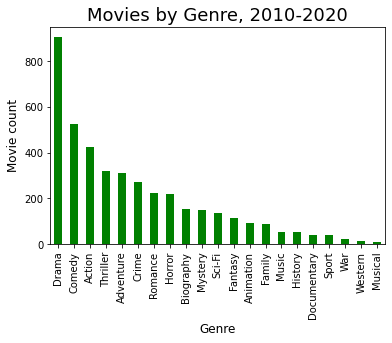

In [265]:
df_split_genre['genre_split'].value_counts().plot(kind='bar', color='g');
plt.title('Movies by Genre, 2010-2020', size=18)
plt.xlabel('Genre', size=12)
plt.ylabel('Movie count', size=12);

In terms of the number of releases worldwide, dramas and comedies top the list ( in North America) between 2010 and 2020 as more than 500 comedy films were released and over 900 drama films have been released.

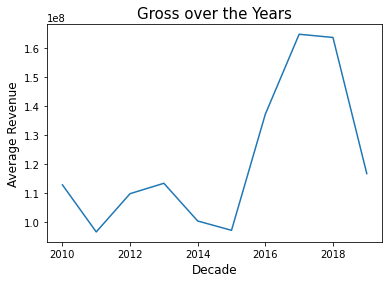

In [266]:
#line gross
# df_split_genre['start_year']= df_split_genre['release_date'].dt.year
gross_mean= df_split_genre.groupby(df_split_genre['start_year'])['worldwide_gross'].mean()
#print(gross_mean)
plt.plot(gross_mean)
plt.title('Gross over the Years', size=15);
plt.xlabel('Decade', size=12)
plt.ylabel('Average Revenue', size=12);

In [267]:
df_split_genre.groupby('genre_split')['profit_ratio'].mean().sort_values()

genre_split
Western       -0.622319
War           -0.587278
Crime         -0.164489
History        0.266524
Documentary    0.321436
Action         0.427784
Family         0.638668
Adventure      0.807443
Sci-Fi         0.908304
Comedy         1.012376
Musical        1.044695
Drama          1.095569
Biography      1.206572
Music          1.285142
Romance        1.312850
Sport          1.405421
Animation      1.470284
Fantasy        1.548981
Thriller       3.782811
Horror         6.269693
Mystery        6.941711
Name: profit_ratio, dtype: float64

In [268]:
genre_profit=df_split_genre[['genre_split','profit_ratio']].sort_values('genre_split').reset_index(level=0, drop=True)
# # generate a boxplot to see the data distribution by treatments. Using boxplot, we can 
# # easily detect the differences between different genre

# ax = sns.boxplot(x='genre_split', y='profit_ratio', data=genre_profit)
# plt.xticks(rotation=45)

# plt.show()

### Hypothesis testing

<span style="color: red;">TODO</span>  
Declare H0/HA; set alpha=0.05

In [269]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Ordinary Least Squares (OLS) model
model = ols('profit_ratio ~ C(genre_split)', data=genre_profit).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table


,sum_sq,df,F,PR(>F)
C(genre_split),13114.623621,20.0,4.176862,1.264954e-09
Residual,648845.153437,4133.0,NaN,NaN


The p value obtained from ANOVA analysis is significant (p < 0.05), and therefore, we conclude that there are significant differences among genre.

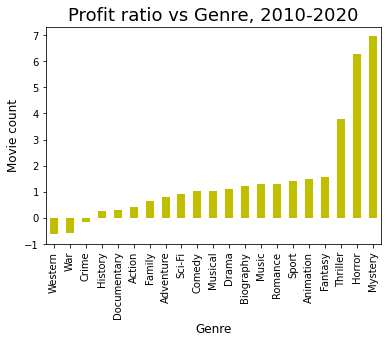

In [270]:
profit_ratio_genre=df_split_genre.groupby('genre_split')['profit_ratio'].mean().sort_values()
profit_ratio_genre.plot(kind='bar', color='y');
plt.title('Profit ratio vs Genre, 2010-2020', size=18)
plt.xlabel('Genre', size=12)
plt.ylabel('Movie count', size=12);

In [271]:
  
# display model summary
#print(model.summary())


From ANOVA analysis, we know that genre differences are statistically significant, but ANOVA does not tell which genre are significantly different from each other. To know the pairs of significant different treatments, we will perform multiple pairwise comparison (post hoc comparison) analysis for all unplanned comparison using Tukey’s honestly significantly differenced (HSD) test.

Note: When the ANOVA is significant, post hoc tests are used to see differences between specific groups. post hoc tests control the family-wise error rate (inflated type I error rate) due to multiple comparisons. post hoc tests adjust the p values (Bonferroni correction) or critical value (Tukey's HSD test).

We have Tukey’s HSD test for multiple comparisons and corrects for family-wise error rate (FWER) (inflated type I error)
 
 
 Link reference:https://www.reneshbedre.com/blog/anova.html

In [272]:
# !pip install bioinfokit;

In [273]:
# we will use bioinfokit (v1.0.3 or later) for performing tukey HSD test
# check documentation here https://github.com/reneshbedre/bioinfokit
##install bioinfokit package
from bioinfokit.analys import stat
# perform multiple pairwise comparison (Tukey's HSD)
# unequal sample size data, tukey_hsd uses Tukey-Kramer test
res = stat()
res.tukey_hsd(df=genre_profit, res_var='profit_ratio', xfac_var='genre_split', anova_model='profit_ratio ~ C(genre_split)')
res.tukey_summary

,group1,group2,Diff,Lower,Upper,q-value,p-value
0,Action,Adventure,0.379659,-2.958043,3.717362,0.574543,0.9
1,Action,Animation,1.042500,-4.057050,6.142049,1.032571,0.9
2,Action,Biography,0.778788,-3.459530,5.017105,0.928115,0.9
3,Action,Comedy,0.584592,-2.334785,3.503969,1.011437,0.9
4,Action,Crime,0.592273,-2.884896,4.069442,0.860344,0.9
...,...,...,...,...,...,...,...
205,Sport,War,1.992699,-9.772479,13.757876,0.855498,0.9
206,Sport,Western,2.027741,-11.914754,15.970235,0.734595,0.9
207,Thriller,War,4.370089,-5.290576,14.030753,2.284858,0.9
208,Thriller,Western,4.405130,-7.813797,16.624058,1.820965,0.9


In [274]:
##filter p-value less than 0.05
res.tukey_summary[res.tukey_summary['p-value']< 0.05].sort_values('p-value')

,group1,group2,Diff,Lower,Upper,q-value,p-value
10,Action,Horror,5.841909,2.126565,9.557253,7.942036,0.001000
125,Drama,Mystery,5.846141,1.878267,9.814016,7.441962,0.001000
122,Drama,Horror,5.174124,1.810251,8.537996,7.769147,0.001000
98,Crime,Mystery,7.106200,2.532261,11.680139,7.847351,0.001000
83,Comedy,Mystery,5.929335,1.763644,10.095025,7.189439,0.001000
80,Comedy,Horror,5.257317,1.662239,8.852395,7.386383,0.001000
95,Crime,Horror,6.434182,2.373083,10.495282,8.002502,0.001000
32,Adventure,Mystery,6.134267,1.665434,10.603101,6.933373,0.001000
29,Adventure,Horror,5.462250,1.519905,9.404594,6.998307,0.001000
13,Action,Mystery,6.513927,2.244012,10.783841,7.705481,0.001000


Above results from Tukey’s HSD suggests that all other pairwise comparisons for treatments rejects null hypothesis (p < 0.05) and indicates statistical significant differences.

# Nate work
<span style='color: red'>TODO</span>  
Rename this

### Creating New Columns
<span style="color: red;">TODO</span>  
Add markdown to explain feature engineering

In [275]:
reviews['num_stars'] = reviews['rating'].map(lambda x : float(x.split('/')[0]))
reviews['out_of_stars'] = reviews['rating'].map(lambda x : float(x.split('/')[1]))
reviews['rating_out_of_10'] = reviews['num_stars'] / reviews['out_of_stars'] * 10
reviews.head()

,id,review,rating,fresh,critic,top_critic,publisher,date,num_stars,out_of_stars,rating_out_of_10
0,3,A distinctly gallows take on contemporary fina...,3/5,1.0,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018",3.0,5.0,6.0
1,3,It's an allegory in search of a meaning that n...,-1/1,0.0,Annalee Newitz,0,io9.com,"May 23, 2018",-1.0,1.0,-10.0
2,3,... life lived in a bubble in financial dealin...,-1/1,1.0,Sean Axmaker,0,Stream on Demand,"January 4, 2018",-1.0,1.0,-10.0
3,3,Continuing along a line introduced in last yea...,-1/1,1.0,Daniel Kasman,0,MUBI,"November 16, 2017",-1.0,1.0,-10.0
4,3,... a perverse twist on neorealism...,-1/1,1.0,NaN,0,Cinema Scope,"October 12, 2017",-1.0,1.0,-10.0


In [276]:
reviews['rating'].replace('-1/1', np.nan, inplace=True)
reviews['num_stars'].replace(-1.0, np.nan, inplace=True)
reviews['out_of_stars'].replace(1.0, np.nan, inplace=True)
reviews['rating_out_of_10'].replace(-10.0, np.nan, inplace=True)

# Exploratory Data Analysis on Rotten Tomatoes Reviews

In [277]:
reviews.head()

,id,review,rating,fresh,critic,top_critic,publisher,date,num_stars,out_of_stars,rating_out_of_10
0,3,A distinctly gallows take on contemporary fina...,3/5,1.0,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018",3.0,5.0,6.0
1,3,It's an allegory in search of a meaning that n...,NaN,0.0,Annalee Newitz,0,io9.com,"May 23, 2018",NaN,NaN,NaN
2,3,... life lived in a bubble in financial dealin...,NaN,1.0,Sean Axmaker,0,Stream on Demand,"January 4, 2018",NaN,NaN,NaN
3,3,Continuing along a line introduced in last yea...,NaN,1.0,Daniel Kasman,0,MUBI,"November 16, 2017",NaN,NaN,NaN
4,3,... a perverse twist on neorealism...,NaN,1.0,NaN,0,Cinema Scope,"October 12, 2017",NaN,NaN,NaN


In [278]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54423 entries, 0 to 54431
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                54423 non-null  int64  
 1   review            48867 non-null  object 
 2   rating            40129 non-null  object 
 3   fresh             54423 non-null  float64
 4   critic            51710 non-null  object 
 5   top_critic        54423 non-null  int64  
 6   publisher         54114 non-null  object 
 7   date              54423 non-null  object 
 8   num_stars         40129 non-null  float64
 9   out_of_stars      40129 non-null  float64
 10  rating_out_of_10  40129 non-null  float64
dtypes: float64(4), int64(2), object(5)
memory usage: 5.0+ MB


In [279]:
len(reviews)

54423

In [280]:
reviews.loc[reviews['rating'].isna() == False].head()

,id,review,rating,fresh,critic,top_critic,publisher,date,num_stars,out_of_stars,rating_out_of_10
0,3,A distinctly gallows take on contemporary fina...,3/5,1.0,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018",3.0,5.0,6.0
6,3,"Quickly grows repetitive and tiresome, meander...",5.8/10,0.0,Eric D. Snider,0,EricDSnider.com,"July 17, 2013",5.8,10.0,5.8
7,3,Cronenberg is not a director to be daunted by ...,2/5,0.0,Matt Kelemen,0,Las Vegas CityLife,"April 21, 2013",2.0,5.0,4.0
11,3,"While not one of Cronenberg's stronger films, ...",4.2/10,1.0,Emanuel Levy,0,EmanuelLevy.Com,"February 3, 2013",4.2,10.0,4.2
12,3,Robert Pattinson works mighty hard to make Cos...,2/4,0.0,Christian Toto,0,Big Hollywood,"January 15, 2013",2.0,4.0,5.0


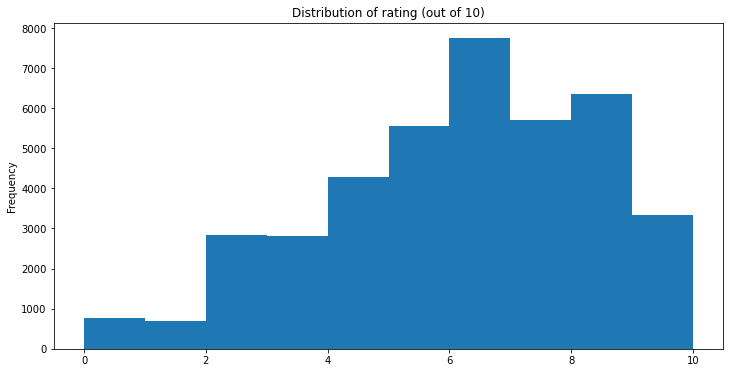

In [281]:
reviews['rating_out_of_10'].plot(figsize=(12,6), kind='hist', title='Distribution of rating (out of 10)');

In [282]:
reviews['rating_out_of_10'].mean()

5.91708490119365

In [283]:
reviews['rating_out_of_10'].median()

6.0

In [284]:
reviews['rating_out_of_10'].mode()

0    6.0
dtype: float64

In [285]:
reviews.groupby('fresh')['id'].count()

fresh
0.0    21391
1.0    33032
Name: id, dtype: int64

We have found that movies average **6 out of 10 stars**. We could consider movies with below 6 out of 10 stars to be below average and movies with above 6 out of 10 stars to be above average.

# Research Question
Do a **director's previous movie ratings** relate to the **profit** that their movies generate?

## Approach
To answer this question, we will begin by creating two groups of directors - those with a "good" average rating, and those with a "bad" average rating. We will determine a threshold by which we can classify ratings as "good" or "bad" by investigating the distribution of Rotten Tomatoes rating data within movies classified by Rotten Tomatoes as "fresh" and those classified as "rotten", as well as considering the results from the exploratory data analysis performed above.

Upon choosing a threshold, we will use IMDB databases joined with movie budget data from The Numbers to calculate mean movie rating by director along with the director's mean profit. In particular, we are interested in established directors - those who have received over 1,000 reviews and have worked on at least two movies. We will then split these directors into two groups - one group with mean ratings of greater than or equal to the threshold, and one with mean ratings below the threshold.

We will then investigate whether there is a relationship between mean rating by director and their mean profit. We will conduct a hypothesis test to determine if the mean profit for established directors with the higher mean ratings is greater than that of established directors with the lower mean ratings.

### Determining a Threshold

In [286]:
rotten_tomatoes = movie_info.merge(reviews, on='id')

In [287]:
rotten_tomatoes.head()

,id,synopsis,rating_x,genre,director,writer,theater_date,dvd_date,currency,box_office,...,review,rating_y,fresh,critic,top_critic,publisher,date,num_stars,out_of_stars,rating_out_of_10
0,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,600000.0,...,A distinctly gallows take on contemporary fina...,3/5,1.0,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018",3.0,5.0,6.0
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,600000.0,...,It's an allegory in search of a meaning that n...,NaN,0.0,Annalee Newitz,0,io9.com,"May 23, 2018",NaN,NaN,NaN
2,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,600000.0,...,... life lived in a bubble in financial dealin...,NaN,1.0,Sean Axmaker,0,Stream on Demand,"January 4, 2018",NaN,NaN,NaN
3,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,600000.0,...,Continuing along a line introduced in last yea...,NaN,1.0,Daniel Kasman,0,MUBI,"November 16, 2017",NaN,NaN,NaN
4,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,600000.0,...,... a perverse twist on neorealism...,NaN,1.0,NaN,0,Cinema Scope,"October 12, 2017",NaN,NaN,NaN


In [288]:
fresh_reviews = rotten_tomatoes.loc[rotten_tomatoes['fresh'] == 1]
rotten_reviews = rotten_tomatoes.loc[rotten_tomatoes['fresh'] == 0]

C:\Users\clineman\Anaconda3\envs\learn-env\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\clineman\Anaconda3\envs\learn-env\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


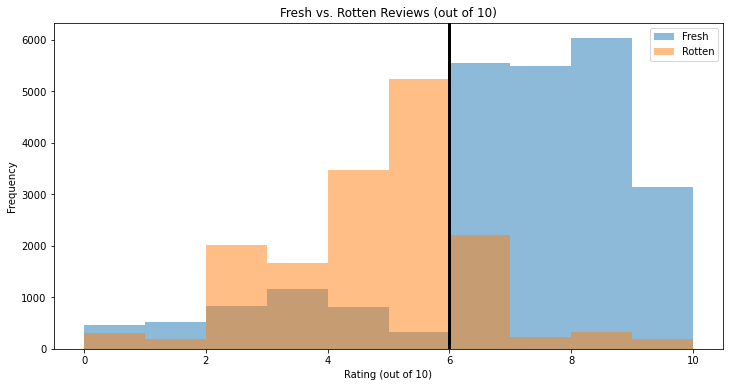

In [289]:
fig, ax = plt.subplots(figsize=(12,6))
ax.hist(fresh_reviews['rating_out_of_10'], alpha=0.5)
ax.hist(rotten_reviews['rating_out_of_10'], alpha=0.5)
ax.set_title("Fresh vs. Rotten Reviews (out of 10)")
ax.set_xlabel("Rating (out of 10)")
ax.set_ylabel("Frequency")
ax.legend(['Fresh','Rotten'])
plt.axvline(x=6, color='black', lw=3);

Based upon the visualization above, as well as the distribution of ratings investigated in the preceding exploratory data analysis on Rotten Tomatoes reviews, we will set our threshold to **6 out of 10**.

### Gathering Data

In [290]:
movie_budgets['profit'] = movie_budgets['worldwide_gross']-movie_budgets['production_budget']

In [291]:
directorRatings = pd.read_sql("""
    SELECT 
    persons.primary_name AS director, movie_basics.original_title AS title, movie_ratings.averagerating AS AVG_Movie_rating
    FROM persons
    JOIN principals
        USING(person_id)
    JOIN movie_basics
        USING(movie_id)
    JOIN movie_ratings
        USING(movie_id)
    GROUP BY persons.primary_name
    HAVING principals.category == 'director' AND movie_ratings.numvotes >= 1000 AND COUNT(movie_ratings.movie_id) > 1
    ORDER BY AVG_Movie_rating DESC
  ;
""", conn)

In [292]:
directorRatings['title'] = directorRatings['title'].str.upper()

In [293]:
directorRatings.head()

,director,title,AVG_Movie_rating
0,Tim Gagliardo,WHEELS,9.3
1,Murat Dündar,CM101MMXI FUNDAMENTALS,9.2
2,Dipendra K. Khanal,PASHUPATI PRASAD,9.0
3,Tomasz Sekielski,TYLKO NIE MÓW NIKOMU,8.9
4,Hemanth M. Rao,GODHI BANNA SADHARANA MYKATTU,8.9


In [294]:
movie_budgets.head()

,id,release_date,title,production_budget,domestic_gross,worldwide_gross,profit
0,1,2009-12-18,AVATAR,425000000.0,760507625.0,2.776345e+09,2.351345e+09
1,2,2011-05-20,PIRATES OF THE CARIBBEAN ON STRANGER TIDES,410600000.0,241063875.0,1.045664e+09,6.350639e+08
2,3,2019-06-07,DARK PHOENIX,350000000.0,42762350.0,1.497624e+08,-2.002376e+08
3,4,2015-05-01,AVENGERS AGE OF ULTRON,330600000.0,459005868.0,1.403014e+09,1.072414e+09
4,5,2017-12-15,STAR WARS EP VIII THE LAST JEDI,317000000.0,620181382.0,1.316722e+09,9.997217e+08


In [295]:
budgetJoinDirector = movie_budgets.merge(directorRatings, left_on = 'title', right_on='title')

In [296]:
budgetJoinDirector.head()

,id,release_date,title,production_budget,domestic_gross,worldwide_gross,profit,director,AVG_Movie_rating
0,14,2012-03-09,JOHN CARTER,275000000.0,73058679.0,2.827781e+08,7.778100e+06,Andrew Stanton,6.6
1,15,2010-11-24,TANGLED,260000000.0,200821936.0,5.864772e+08,3.264772e+08,Byron Howard,7.8
2,27,2012-05-04,THE AVENGERS,225000000.0,623279547.0,1.517936e+09,1.292936e+09,Joss Whedon,8.1
3,35,1998-08-14,THE AVENGERS,60000000.0,23385416.0,4.858542e+07,-1.141458e+07,Joss Whedon,8.1
4,34,2015-06-12,JURASSIC WORLD,215000000.0,652270625.0,1.648855e+09,1.433855e+09,Colin Trevorrow,7.0


In [297]:
budgetJoinDirector.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 517 entries, 0 to 516
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 517 non-null    int64         
 1   release_date       517 non-null    datetime64[ns]
 2   title              517 non-null    object        
 3   production_budget  517 non-null    float64       
 4   domestic_gross     517 non-null    float64       
 5   worldwide_gross    517 non-null    float64       
 6   profit             517 non-null    float64       
 7   director           517 non-null    object        
 8   AVG_Movie_rating   517 non-null    float64       
dtypes: datetime64[ns](1), float64(5), int64(1), object(2)
memory usage: 40.4+ KB


To obtain relevant data, we will only focus on data since **2010**:

In [298]:
budgetJoinDirector['year'] = budgetJoinDirector['release_date'].dt.year

In [299]:
budgetJoinDirector['year'].unique()

array([2012, 2010, 1998, 2015, 2018, 1951, 2011, 2013, 1974, 2016, 2014,
       1984, 2009, 1981, 1990, 1987, 2005, 2017, 1982, 1995, 2000, 2006,
       2001, 2019, 1989, 2007, 1988, 2008], dtype=int64)

In [300]:
budgetJoinDirector = budgetJoinDirector.loc[budgetJoinDirector['year'] >= 2010]

In [301]:
budgetJoinDirector.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 486 entries, 0 to 516
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 486 non-null    int64         
 1   release_date       486 non-null    datetime64[ns]
 2   title              486 non-null    object        
 3   production_budget  486 non-null    float64       
 4   domestic_gross     486 non-null    float64       
 5   worldwide_gross    486 non-null    float64       
 6   profit             486 non-null    float64       
 7   director           486 non-null    object        
 8   AVG_Movie_rating   486 non-null    float64       
 9   year               486 non-null    int64         
dtypes: datetime64[ns](1), float64(5), int64(2), object(2)
memory usage: 41.8+ KB


In [302]:
budgetJoinDirector['year'].unique()

array([2012, 2010, 2015, 2018, 2011, 2013, 2016, 2014, 2017, 2019],
      dtype=int64)

In [303]:
budgetJoinDirector=budgetJoinDirector.drop('id', axis =1)
budgetJoinDirector=budgetJoinDirector.drop('release_date', axis =1)
budgetJoinDirector=budgetJoinDirector.drop('title', axis =1)


In [304]:
budgetJoinDirector['profit'] = budgetJoinDirector['worldwide_gross']-budgetJoinDirector['production_budget']
budgetJoinDirector['profitRatio'] = (budgetJoinDirector['worldwide_gross'] - budgetJoinDirector['production_budget'])/ budgetJoinDirector['production_budget']

In [305]:
budgetJoinDirector.head()

,production_budget,domestic_gross,worldwide_gross,profit,director,AVG_Movie_rating,year,profitRatio
0,275000000.0,73058679.0,2.827781e+08,7.778100e+06,Andrew Stanton,6.6,2012,0.028284
1,260000000.0,200821936.0,5.864772e+08,3.264772e+08,Byron Howard,7.8,2010,1.255682
2,225000000.0,623279547.0,1.517936e+09,1.292936e+09,Joss Whedon,8.1,2012,5.746382
4,215000000.0,652270625.0,1.648855e+09,1.433855e+09,Colin Trevorrow,7.0,2015,6.669092
5,215000000.0,179020854.0,6.542135e+08,4.392135e+08,Barry Sonnenfeld,6.8,2012,2.042853


In [306]:
budgetJoinDirector.groupby('director').mean().sort_values('AVG_Movie_rating', ascending = False)

,production_budget,domestic_gross,worldwide_gross,profit,AVG_Movie_rating,year,profitRatio
director,,,,,,,
Lee Unkrich,200000000.0,415004880.0,1.068880e+09,868879522.0,8.3,2010.0,4.344398
Charles Ferguson,2000000.0,4311834.0,7.799257e+06,5799257.0,8.3,2010.0,2.899628
Denis Villeneuve,6800000.0,6857096.0,1.603834e+07,9238343.0,8.3,2010.0,1.358580
Sadyk Sher-Niyaz,1400000.0,0.0,0.000000e+00,-1400000.0,8.3,2014.0,-1.000000
Asghar Farhadi,800000.0,7098492.0,2.442617e+07,23626169.0,8.3,2011.0,29.532711
...,...,...,...,...,...,...,...
Aaron Seltzer,20000000.0,36661504.0,8.142499e+07,61424988.0,3.4,2010.0,3.071249
Jason Friedberg,20000000.0,36661504.0,8.142499e+07,61424988.0,3.4,2010.0,3.071249
Gabriela Tagliavini,4700000.0,0.0,0.000000e+00,-4700000.0,3.3,2011.0,-1.000000


In [307]:
budgetJoinDirector['positive_review'] = budgetJoinDirector['AVG_Movie_rating'] >= 6

In [308]:
grouped = budgetJoinDirector.groupby('director').mean().sort_values('AVG_Movie_rating', ascending = False)
grouped.head()

,production_budget,domestic_gross,worldwide_gross,profit,AVG_Movie_rating,year,profitRatio,positive_review
director,,,,,,,,
Lee Unkrich,200000000.0,415004880.0,1.068880e+09,868879522.0,8.3,2010.0,4.344398,True
Charles Ferguson,2000000.0,4311834.0,7.799257e+06,5799257.0,8.3,2010.0,2.899628,True
Denis Villeneuve,6800000.0,6857096.0,1.603834e+07,9238343.0,8.3,2010.0,1.358580,True
Sadyk Sher-Niyaz,1400000.0,0.0,0.000000e+00,-1400000.0,8.3,2014.0,-1.000000,True
Asghar Farhadi,800000.0,7098492.0,2.442617e+07,23626169.0,8.3,2011.0,29.532711,True


### Investigating Data

<span style="color: red;">TODO</span>  
Elaborate on profit vs. profit ratio comparisons

In [309]:
avg_movie_rating = grouped['AVG_Movie_rating']
avg_profit = grouped['profit']
profitRatioGroup = grouped['profitRatio']

In [310]:
avg_movie_rating

director
Lee Unkrich            8.3
Charles Ferguson       8.3
Denis Villeneuve       8.3
Sadyk Sher-Niyaz       8.3
Asghar Farhadi         8.3
                      ... 
Aaron Seltzer          3.4
Jason Friedberg        3.4
Gabriela Tagliavini    3.3
Dennis Dugan           3.3
Vic Armstrong          3.1
Name: AVG_Movie_rating, Length: 484, dtype: float64

In [311]:
avg_profit

director
Lee Unkrich            868879522.0
Charles Ferguson         5799257.0
Denis Villeneuve         9238343.0
Sadyk Sher-Niyaz        -1400000.0
Asghar Farhadi          23626169.0
                          ...     
Aaron Seltzer           61424988.0
Jason Friedberg         61424988.0
Gabriela Tagliavini     -4700000.0
Dennis Dugan            71519217.0
Vic Armstrong            4769209.0
Name: profit, Length: 484, dtype: float64

In [312]:
profitRatioGroup

director
Lee Unkrich             4.344398
Charles Ferguson        2.899628
Denis Villeneuve        1.358580
Sadyk Sher-Niyaz       -1.000000
Asghar Farhadi         29.532711
                         ...    
Aaron Seltzer           3.071249
Jason Friedberg         3.071249
Gabriela Tagliavini    -1.000000
Dennis Dugan            0.905307
Vic Armstrong           0.298076
Name: profitRatio, Length: 484, dtype: float64

C:\Users\clineman\Anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of mean movie rating per director')

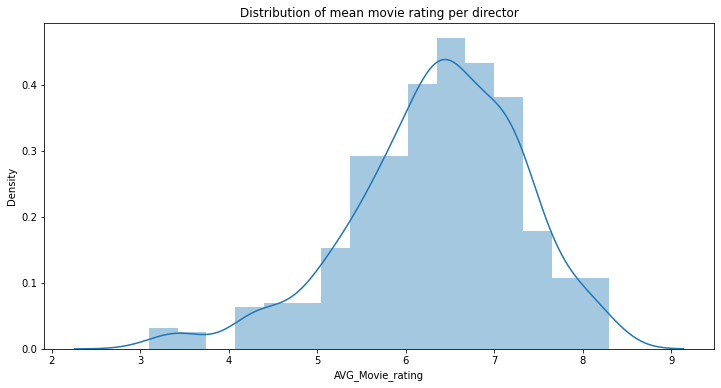

In [313]:
fig, ax = plt.subplots(figsize=(12,6))
sns.distplot(avg_movie_rating)
ax.set_title('Distribution of mean movie rating per director')

C:\Users\clineman\Anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of mean profit per director')

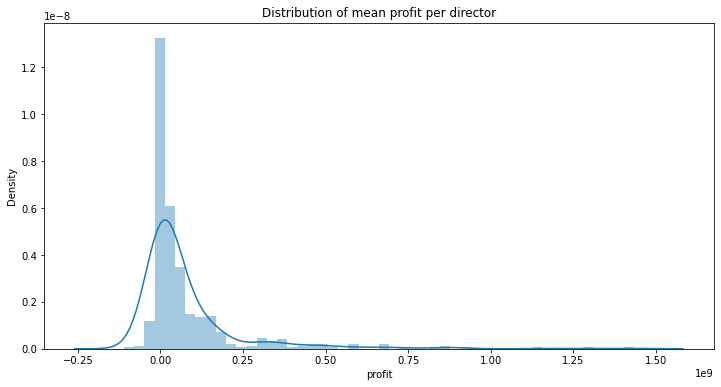

In [314]:
fig, ax = plt.subplots(figsize=(12,6))
sns.distplot(avg_profit)
ax.set_title('Distribution of mean profit per director')

C:\Users\clineman\Anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of profit Ratio per director')

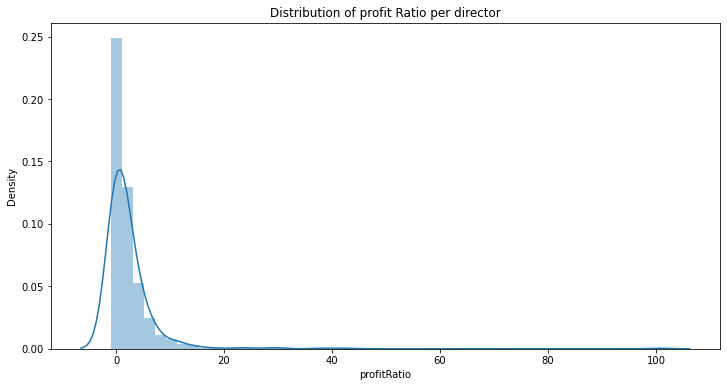

In [315]:
fig, ax = plt.subplots(figsize=(12,6))
sns.distplot(profitRatioGroup)
ax.set_title('Distribution of profit Ratio per director')

In [316]:
grouped

,production_budget,domestic_gross,worldwide_gross,profit,AVG_Movie_rating,year,profitRatio,positive_review
director,,,,,,,,
Lee Unkrich,200000000.0,415004880.0,1.068880e+09,868879522.0,8.3,2010.0,4.344398,True
Charles Ferguson,2000000.0,4311834.0,7.799257e+06,5799257.0,8.3,2010.0,2.899628,True
Denis Villeneuve,6800000.0,6857096.0,1.603834e+07,9238343.0,8.3,2010.0,1.358580,True
Sadyk Sher-Niyaz,1400000.0,0.0,0.000000e+00,-1400000.0,8.3,2014.0,-1.000000,True
Asghar Farhadi,800000.0,7098492.0,2.442617e+07,23626169.0,8.3,2011.0,29.532711,True
...,...,...,...,...,...,...,...,...
Aaron Seltzer,20000000.0,36661504.0,8.142499e+07,61424988.0,3.4,2010.0,3.071249,False
Jason Friedberg,20000000.0,36661504.0,8.142499e+07,61424988.0,3.4,2010.0,3.071249,False
Gabriela Tagliavini,4700000.0,0.0,0.000000e+00,-4700000.0,3.3,2011.0,-1.000000,False


In [317]:
avg_movie_rating

director
Lee Unkrich            8.3
Charles Ferguson       8.3
Denis Villeneuve       8.3
Sadyk Sher-Niyaz       8.3
Asghar Farhadi         8.3
                      ... 
Aaron Seltzer          3.4
Jason Friedberg        3.4
Gabriela Tagliavini    3.3
Dennis Dugan           3.3
Vic Armstrong          3.1
Name: AVG_Movie_rating, Length: 484, dtype: float64

In [318]:
profitRatioGroup

director
Lee Unkrich             4.344398
Charles Ferguson        2.899628
Denis Villeneuve        1.358580
Sadyk Sher-Niyaz       -1.000000
Asghar Farhadi         29.532711
                         ...    
Aaron Seltzer           3.071249
Jason Friedberg         3.071249
Gabriela Tagliavini    -1.000000
Dennis Dugan            0.905307
Vic Armstrong           0.298076
Name: profitRatio, Length: 484, dtype: float64

It appears that our profit data contains several outliers. We will trim these outliers using the **IQR rule** before proceeding with our analysis so we can focus on typical profits.

### Investigating Trimmed Data

In [319]:
Q1 = grouped['profit'].quantile(0.25)
Q3 = grouped['profit'].quantile(0.75)
IQR = Q3-Q1
grouped_trimmed = grouped.loc[(grouped['profit'] >= Q1-1.5*IQR) & (grouped['profit'] <= Q3 + 1.5*IQR)]

avg_movie_rating = grouped_trimmed['AVG_Movie_rating']
avg_profit = grouped_trimmed['profit']
#profitRatioGroup = grouped_trimmed['profitRatio']



In [320]:
Q1 = grouped['profitRatio'].quantile(0.25)
Q3 = grouped['profitRatio'].quantile(0.75)
IQR = Q3-Q1

grouped_clean = grouped.loc[(grouped['profitRatio'] >= Q1-(1.5*IQR)) & (grouped['profitRatio'] <= Q3 + 1.5*IQR)]

profitRatio = grouped_clean['profitRatio']
avg_movie_rating_ratio = grouped_clean['AVG_Movie_rating']

In [321]:
profitRatio

director
Lee Unkrich            4.344398
Charles Ferguson       2.899628
Denis Villeneuve       1.358580
Sadyk Sher-Niyaz      -1.000000
Anonymous              0.227316
                         ...   
Aaron Seltzer          3.071249
Jason Friedberg        3.071249
Gabriela Tagliavini   -1.000000
Dennis Dugan           0.905307
Vic Armstrong          0.298076
Name: profitRatio, Length: 450, dtype: float64

In [322]:
avg_movie_rating_ratio

director
Lee Unkrich            8.3
Charles Ferguson       8.3
Denis Villeneuve       8.3
Sadyk Sher-Niyaz       8.3
Anonymous              8.2
                      ... 
Aaron Seltzer          3.4
Jason Friedberg        3.4
Gabriela Tagliavini    3.3
Dennis Dugan           3.3
Vic Armstrong          3.1
Name: AVG_Movie_rating, Length: 450, dtype: float64

In [323]:
len(grouped_trimmed)

434

C:\Users\clineman\Anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of mean movie rating per director')

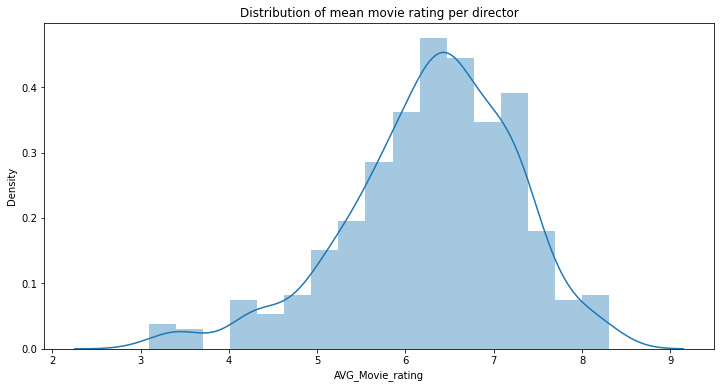

In [324]:
fig, ax = plt.subplots(figsize=(12,6))
sns.distplot(avg_movie_rating)
ax.set_title('Distribution of mean movie rating per director')

C:\Users\clineman\Anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


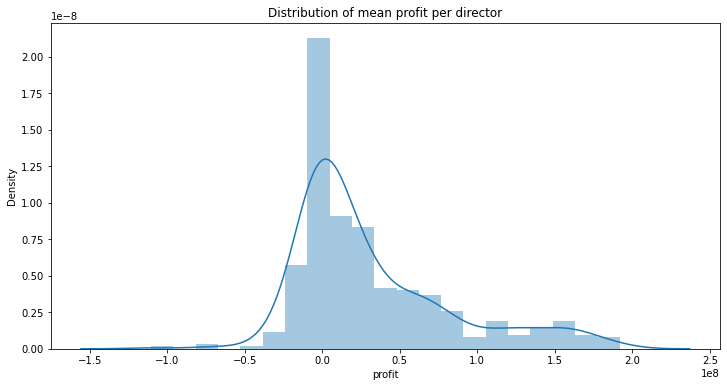

In [325]:
fig, ax = plt.subplots(figsize=(12,6))
sns.distplot(avg_profit)
ax.set_title('Distribution of mean profit per director');

C:\Users\clineman\Anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of profit Ratio per director')

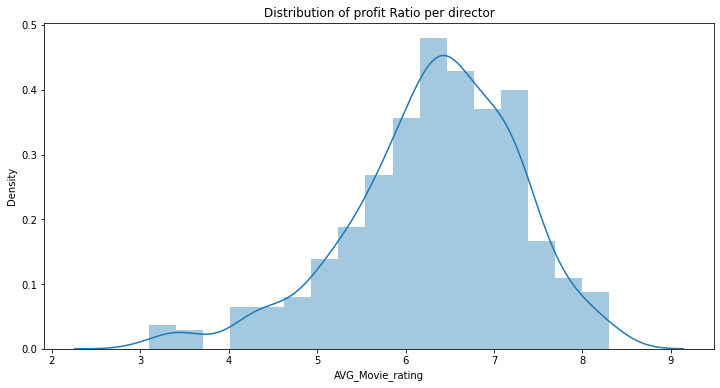

In [326]:
fig, ax = plt.subplots(figsize=(12,6))
sns.distplot(avg_movie_rating_ratio)
ax.set_title('Distribution of profit Ratio per director')


C:\Users\clineman\Anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of profit Ratio per director')

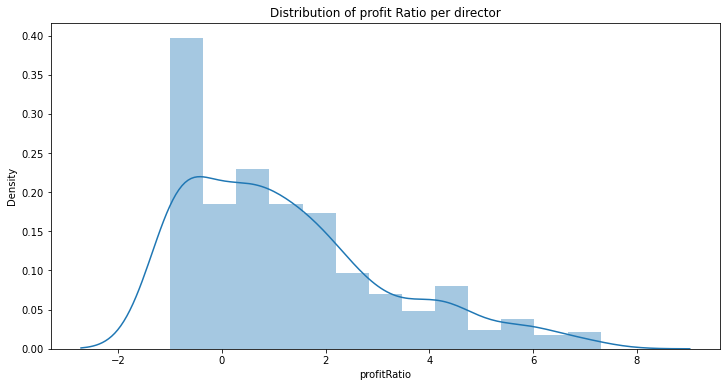

In [327]:
fig, ax = plt.subplots(figsize=(12,6))
sns.distplot(profitRatio)
ax.set_title('Distribution of profit Ratio per director')

In [328]:
greaterThanEqual6_trimmed = grouped_trimmed.loc[avg_movie_rating >= 6]['profit']
lessThan6_trimmed = grouped_trimmed.loc[avg_movie_rating < 6]['profit']

In [329]:
greaterThanEqual6_trimmed

director
Charles Ferguson      5799257.0
Denis Villeneuve      9238343.0
Sadyk Sher-Niyaz     -1400000.0
Asghar Farhadi       23626169.0
Anonymous              227316.0
                       ...     
Tarsem Singh        136562435.0
Bryan Buckley        -2884184.0
Jim Sheridan         -8357834.0
Jake Szymanski       42898100.0
Paul McGuigan        -8875633.0
Name: profit, Length: 297, dtype: float64

In [330]:
lessThan6_trimmed

director
Jay Roach                17796502.0
Todd Robinson           -16800490.0
Rob Greenberg            73369830.0
Shari Springer Berman    -6507892.0
Alister Grierson         78957098.0
                            ...    
Aaron Seltzer            61424988.0
Jason Friedberg          61424988.0
Gabriela Tagliavini      -4700000.0
Dennis Dugan             71519217.0
Vic Armstrong             4769209.0
Name: profit, Length: 137, dtype: float64

In [331]:
greaterThanEqual6_trimmed_ratio = grouped_clean.loc[grouped_clean['AVG_Movie_rating'] >= 6]['profitRatio']
lessThan6_trimmed_ratio = grouped_clean.loc[grouped_clean['AVG_Movie_rating'] < 6]['profitRatio']

In [332]:
profitRatio

director
Lee Unkrich            4.344398
Charles Ferguson       2.899628
Denis Villeneuve       1.358580
Sadyk Sher-Niyaz      -1.000000
Anonymous              0.227316
                         ...   
Aaron Seltzer          3.071249
Jason Friedberg        3.071249
Gabriela Tagliavini   -1.000000
Dennis Dugan           0.905307
Vic Armstrong          0.298076
Name: profitRatio, Length: 450, dtype: float64

In [333]:
avg_movie_rating_ratio

director
Lee Unkrich            8.3
Charles Ferguson       8.3
Denis Villeneuve       8.3
Sadyk Sher-Niyaz       8.3
Anonymous              8.2
                      ... 
Aaron Seltzer          3.4
Jason Friedberg        3.4
Gabriela Tagliavini    3.3
Dennis Dugan           3.3
Vic Armstrong          3.1
Name: AVG_Movie_rating, Length: 450, dtype: float64

In [334]:
greaterThanEqual6_trimmed_ratio

director
Lee Unkrich         4.344398
Charles Ferguson    2.899628
Denis Villeneuve    1.358580
Sadyk Sher-Niyaz   -1.000000
Anonymous           0.227316
                      ...   
Tarsem Singh        1.820832
Bryan Buckley      -0.824053
Jim Sheridan       -0.167157
Jake Szymanski      1.299942
Paul McGuigan      -0.221891
Name: profitRatio, Length: 315, dtype: float64

In [335]:
lessThan6_trimmed_ratio

director
Jay Roach                0.257920
Todd Robinson           -0.933361
Rob Greenberg            6.114153
Shari Springer Berman   -0.929699
Alister Grierson         2.631903
                           ...   
Aaron Seltzer            3.071249
Jason Friedberg          3.071249
Gabriela Tagliavini     -1.000000
Dennis Dugan             0.905307
Vic Armstrong            0.298076
Name: profitRatio, Length: 135, dtype: float64

<span style='color: red'>TODO</span>  
Nate: Move these plots to a side-by-side format

C:\Users\clineman\Anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


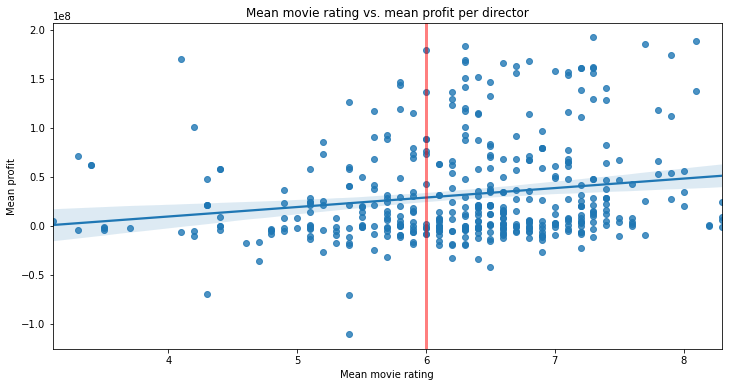

In [336]:
fig, ax = plt.subplots(figsize=(12,6))
ax = sns.regplot(avg_movie_rating, avg_profit)
ax.axvline(6, color='red', lw=3, alpha=0.5);
ax.set_title('Mean movie rating vs. mean profit per director')
ax.set_xlabel('Mean movie rating')
ax.set_ylabel('Mean profit');

C:\Users\clineman\Anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


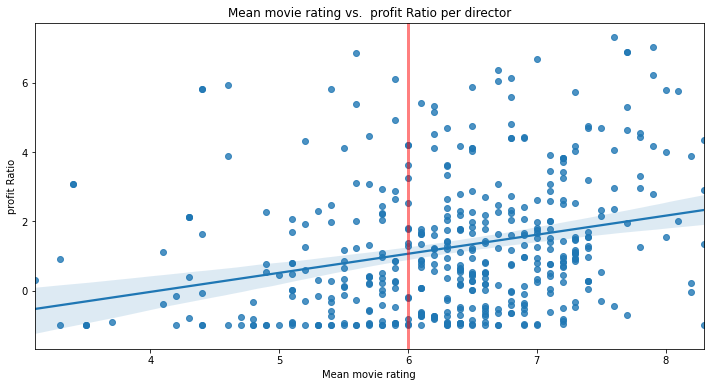

In [337]:
fig, ax = plt.subplots(figsize=(12,6))
ax = sns.regplot(avg_movie_rating_ratio, profitRatio )
ax.axvline(6, color='red', lw=3, alpha=0.5);
ax.set_title('Mean movie rating vs.  profit Ratio per director')
ax.set_xlabel('Mean movie rating')
ax.set_ylabel('profit Ratio');

In [338]:
#for the profit
np.corrcoef(avg_movie_rating, avg_profit)[0][1]

0.180997452442317

In [339]:
greaterThanEqual6_trimmed.mean()

37372798.47979798

In [340]:
lessThan6_trimmed.mean()

18683923.664233577

In [341]:
greaterThanEqual6_trimmed.mean() - lessThan6_trimmed.mean()

18688874.815564405

In [342]:
greaterThanEqual6_trimmed.std(ddof=1)**2

2851196205844287.0

In [343]:
lessThan6_trimmed.std(ddof=1)**2

1744435558069636.8

In [344]:
#fir the profit ratio
np.corrcoef(avg_movie_rating_ratio, profitRatio)[0][1]

0.2689343683676368

#### Observations
* There is a **slight positive correlation** between mean movie rating per director and mean profit.

* The means of these two categories **differ**.
* The variances of these two categories **differ**.

## Rationale and Analysis
<span style="color: red;">TODO</span>  
Consider more simple graphs to visualize things

Using $\alpha=0.05$, we will conduct a one-tailed unpaired Welch's t-test (which does NOT assume that population variances are equal) to test our hypothesis that established directors with a mean rating of greater than or equal to 6 produce a greater mean profit than those with a mean rating of less than 6.

Let:
> $\mu_{GE6}$ denote the mean profit for directors with a mean rating of greater than or equal to 6;

> $\mu_{L6}$ denote the mean profit for directors with a mean rating of less than 6.

$H_{0}: \mu_{GE6} - \mu_{L6} = 0$

$H_{A}: \mu_{GE6} - \mu_{L6} > 0$

In [345]:
#for profit
statistic, pvalue = st.ttest_ind(greaterThanEqual6_trimmed, lessThan6_trimmed, equal_var=False)
pvalue/2

4.686646375630644e-05

In [346]:
#for profit ratio
statistic, pvalue = st.ttest_ind(greaterThanEqual6_trimmed_ratio, lessThan6_trimmed_ratio, equal_var=False)
pvalue/2

5.2855105942360924e-05

### Conclusion
If both groups do produce the same profits, there is approximately a 0.19% chance that we obtain a difference in sample means at least as large as obtained above. Given this probability and $\alpha=0.05$, we conclude that established directors with a mean rating of greater than or equal to 6 produce **greater mean profits** than those with a mean rating of less than 6, with a 5% chance of committing a type I error..

## Recommendation
We recommend that ...  
<span style='color: red'>TODO</span>  
Nate

## Season vs. Profit Ratio

<span style='color: red'>TODO</span>  
Alex D. (or Colton): Create explanatory markdown and comment code  
Drop outliers  
Add intro  
Add conclusion  
Add business suggestion

In [347]:
movie_budgets['release_date'].dt.strftime('%m %d %Y')

0       12 18 2009
1       05 20 2011
2       06 07 2019
3       05 01 2015
4       12 15 2017
           ...    
5777    12 31 2018
5778    04 02 1999
5779    07 13 2005
5780    09 29 2015
5781    08 05 2005
Name: release_date, Length: 5782, dtype: object

In [348]:
release_month = movie_budgets['release_date'].dt.strftime('%m')
movie_budgets['release_month']= release_month
movie_budgets

,id,release_date,title,production_budget,domestic_gross,worldwide_gross,profit,release_month
0,1,2009-12-18,AVATAR,425000000.0,760507625.0,2.776345e+09,2.351345e+09,12
1,2,2011-05-20,PIRATES OF THE CARIBBEAN ON STRANGER TIDES,410600000.0,241063875.0,1.045664e+09,6.350639e+08,05
2,3,2019-06-07,DARK PHOENIX,350000000.0,42762350.0,1.497624e+08,-2.002376e+08,06
3,4,2015-05-01,AVENGERS AGE OF ULTRON,330600000.0,459005868.0,1.403014e+09,1.072414e+09,05
4,5,2017-12-15,STAR WARS EP VIII THE LAST JEDI,317000000.0,620181382.0,1.316722e+09,9.997217e+08,12
...,...,...,...,...,...,...,...,...
5777,78,2018-12-31,RED 11,7000.0,0.0,0.000000e+00,-7.000000e+03,12
5778,79,1999-04-02,FOLLOWING,6000.0,48482.0,2.404950e+05,2.344950e+05,04
5779,80,2005-07-13,RETURN TO THE LAND OF WONDERS,5000.0,1338.0,1.338000e+03,-3.662000e+03,07
5780,81,2015-09-29,A PLAGUE SO PLEASANT,1400.0,0.0,0.000000e+00,-1.400000e+03,09


In [349]:
release_year = movie_budgets['release_date'].dt.strftime('%Y')
movie_budgets['release_year']= release_year
movie_budgets

,id,release_date,title,production_budget,domestic_gross,worldwide_gross,profit,release_month,release_year
0,1,2009-12-18,AVATAR,425000000.0,760507625.0,2.776345e+09,2.351345e+09,12,2009
1,2,2011-05-20,PIRATES OF THE CARIBBEAN ON STRANGER TIDES,410600000.0,241063875.0,1.045664e+09,6.350639e+08,05,2011
2,3,2019-06-07,DARK PHOENIX,350000000.0,42762350.0,1.497624e+08,-2.002376e+08,06,2019
3,4,2015-05-01,AVENGERS AGE OF ULTRON,330600000.0,459005868.0,1.403014e+09,1.072414e+09,05,2015
4,5,2017-12-15,STAR WARS EP VIII THE LAST JEDI,317000000.0,620181382.0,1.316722e+09,9.997217e+08,12,2017
...,...,...,...,...,...,...,...,...,...
5777,78,2018-12-31,RED 11,7000.0,0.0,0.000000e+00,-7.000000e+03,12,2018
5778,79,1999-04-02,FOLLOWING,6000.0,48482.0,2.404950e+05,2.344950e+05,04,1999
5779,80,2005-07-13,RETURN TO THE LAND OF WONDERS,5000.0,1338.0,1.338000e+03,-3.662000e+03,07,2005
5780,81,2015-09-29,A PLAGUE SO PLEASANT,1400.0,0.0,0.000000e+00,-1.400000e+03,09,2015


In [350]:
#Season: spring = 1, summer=2, fall= 3, winter=4
season_dict = {'01': '4',
               '02': '4',
               '03': '1', 
               '04': '1',
               '05': '1',
               '06': '2',
               '07': '2',
               '08': '2',
               '09': '3',
               '10': '3',
               '11': '3',
               '12': '4'}
movie_budgets['Season'] = movie_budgets['release_month'].apply(lambda x: season_dict[x])

In [351]:
movie_budgets['release_year']  = movie_budgets['release_year'].astype("int")
movie_budgets['release_month']  = movie_budgets['release_month'].astype("int")
movie_budgets['Season']  = movie_budgets['Season'].astype("int")

## movie budgets with seasonal data

# Merg Gross and budgets

In [352]:
movie_budgets

,id,release_date,title,production_budget,domestic_gross,worldwide_gross,profit,release_month,release_year,Season
0,1,2009-12-18,AVATAR,425000000.0,760507625.0,2.776345e+09,2.351345e+09,12,2009,4
1,2,2011-05-20,PIRATES OF THE CARIBBEAN ON STRANGER TIDES,410600000.0,241063875.0,1.045664e+09,6.350639e+08,5,2011,1
2,3,2019-06-07,DARK PHOENIX,350000000.0,42762350.0,1.497624e+08,-2.002376e+08,6,2019,2
3,4,2015-05-01,AVENGERS AGE OF ULTRON,330600000.0,459005868.0,1.403014e+09,1.072414e+09,5,2015,1
4,5,2017-12-15,STAR WARS EP VIII THE LAST JEDI,317000000.0,620181382.0,1.316722e+09,9.997217e+08,12,2017,4
...,...,...,...,...,...,...,...,...,...,...
5777,78,2018-12-31,RED 11,7000.0,0.0,0.000000e+00,-7.000000e+03,12,2018,4
5778,79,1999-04-02,FOLLOWING,6000.0,48482.0,2.404950e+05,2.344950e+05,4,1999,1
5779,80,2005-07-13,RETURN TO THE LAND OF WONDERS,5000.0,1338.0,1.338000e+03,-3.662000e+03,7,2005,2
5780,81,2015-09-29,A PLAGUE SO PLEASANT,1400.0,0.0,0.000000e+00,-1.400000e+03,9,2015,3


In [353]:
movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 5782 non-null   int64         
 1   release_date       5782 non-null   datetime64[ns]
 2   title              5782 non-null   object        
 3   production_budget  5782 non-null   float64       
 4   domestic_gross     5782 non-null   float64       
 5   worldwide_gross    5782 non-null   float64       
 6   profit             5782 non-null   float64       
 7   release_month      5782 non-null   int32         
 8   release_year       5782 non-null   int32         
 9   Season             5782 non-null   int32         
dtypes: datetime64[ns](1), float64(4), int32(3), int64(1), object(1)
memory usage: 384.1+ KB


## movie budgets with seasonal data

In [354]:
movie_budgets

,id,release_date,title,production_budget,domestic_gross,worldwide_gross,profit,release_month,release_year,Season
0,1,2009-12-18,AVATAR,425000000.0,760507625.0,2.776345e+09,2.351345e+09,12,2009,4
1,2,2011-05-20,PIRATES OF THE CARIBBEAN ON STRANGER TIDES,410600000.0,241063875.0,1.045664e+09,6.350639e+08,5,2011,1
2,3,2019-06-07,DARK PHOENIX,350000000.0,42762350.0,1.497624e+08,-2.002376e+08,6,2019,2
3,4,2015-05-01,AVENGERS AGE OF ULTRON,330600000.0,459005868.0,1.403014e+09,1.072414e+09,5,2015,1
4,5,2017-12-15,STAR WARS EP VIII THE LAST JEDI,317000000.0,620181382.0,1.316722e+09,9.997217e+08,12,2017,4
...,...,...,...,...,...,...,...,...,...,...
5777,78,2018-12-31,RED 11,7000.0,0.0,0.000000e+00,-7.000000e+03,12,2018,4
5778,79,1999-04-02,FOLLOWING,6000.0,48482.0,2.404950e+05,2.344950e+05,4,1999,1
5779,80,2005-07-13,RETURN TO THE LAND OF WONDERS,5000.0,1338.0,1.338000e+03,-3.662000e+03,7,2005,2
5780,81,2015-09-29,A PLAGUE SO PLEASANT,1400.0,0.0,0.000000e+00,-1.400000e+03,9,2015,3


#### Merge Gross and budgets

In [355]:
movieGrossJoinBudgets = pd.DataFrame.merge(movie_gross, movie_budgets, on = 'title')
movieGrossJoinBudgets

,title,studio,domestic_gross_x,foreign_gross,year,id,release_date,production_budget,domestic_gross_y,worldwide_gross,profit,release_month,release_year,Season
0,TOY STORY 3,BV,415000000.0,652000000.0,2010,47,2010-06-18,200000000.0,415004880.0,1.068880e+09,868879522.0,6,2010,2
1,INCEPTION,WB,292600000.0,535700000.0,2010,38,2010-07-16,160000000.0,292576195.0,8.355246e+08,675524642.0,7,2010,2
2,SHREK FOREVER AFTER,P/DW,238700000.0,513900000.0,2010,27,2010-05-21,165000000.0,238736787.0,7.562447e+08,591244673.0,5,2010,1
3,THE TWILIGHT SAGA ECLIPSE,Sum.,300500000.0,398000000.0,2010,53,2010-06-30,68000000.0,300531751.0,7.061028e+08,638102828.0,6,2010,2
4,IRON MAN 2,Par.,312400000.0,311500000.0,2010,15,2010-05-07,170000000.0,312433331.0,6.211564e+08,451156389.0,5,2010,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1302,BEN IS BACK,RAtt.,3700000.0,NaN,2018,95,2018-12-07,13000000.0,3703182.0,9.633111e+06,-3366889.0,12,2018,4
1303,BILAL A NEW BREED OF HERO,VE,491000.0,1700000.0,2018,100,2018-02-02,30000000.0,490973.0,6.485990e+05,-29351401.0,2,2018,4
1304,MANDY,RLJ,1200000.0,NaN,2018,71,2018-09-14,6000000.0,1214525.0,1.427656e+06,-4572344.0,9,2018,3
1305,LEAN ON PETE,A24,1200000.0,NaN,2018,13,2018-04-06,8000000.0,1163056.0,2.455027e+06,-5544973.0,4,2018,1


In [356]:
movieGrossJoinBudgets.isna().sum()

title                  0
studio                 1
domestic_gross_x       2
foreign_gross        171
year                   0
id                     0
release_date           0
production_budget      0
domestic_gross_y       0
worldwide_gross        0
profit                 0
release_month          0
release_year           0
Season                 0
dtype: int64

In [357]:
movieGrossJoinBudgets.fillna(0, inplace = True)

In [358]:
movieGrossJoinBudgets.isna().sum()

title                0
studio               0
domestic_gross_x     0
foreign_gross        0
year                 0
id                   0
release_date         0
production_budget    0
domestic_gross_y     0
worldwide_gross      0
profit               0
release_month        0
release_year         0
Season               0
dtype: int64

In [359]:
movieGrossJoinBudgets.drop(['domestic_gross_y'], axis=1, inplace=True)
movieGrossJoinBudgets

,title,studio,domestic_gross_x,foreign_gross,year,id,release_date,production_budget,worldwide_gross,profit,release_month,release_year,Season
0,TOY STORY 3,BV,415000000.0,652000000.0,2010,47,2010-06-18,200000000.0,1.068880e+09,868879522.0,6,2010,2
1,INCEPTION,WB,292600000.0,535700000.0,2010,38,2010-07-16,160000000.0,8.355246e+08,675524642.0,7,2010,2
2,SHREK FOREVER AFTER,P/DW,238700000.0,513900000.0,2010,27,2010-05-21,165000000.0,7.562447e+08,591244673.0,5,2010,1
3,THE TWILIGHT SAGA ECLIPSE,Sum.,300500000.0,398000000.0,2010,53,2010-06-30,68000000.0,7.061028e+08,638102828.0,6,2010,2
4,IRON MAN 2,Par.,312400000.0,311500000.0,2010,15,2010-05-07,170000000.0,6.211564e+08,451156389.0,5,2010,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1302,BEN IS BACK,RAtt.,3700000.0,0.0,2018,95,2018-12-07,13000000.0,9.633111e+06,-3366889.0,12,2018,4
1303,BILAL A NEW BREED OF HERO,VE,491000.0,1700000.0,2018,100,2018-02-02,30000000.0,6.485990e+05,-29351401.0,2,2018,4
1304,MANDY,RLJ,1200000.0,0.0,2018,71,2018-09-14,6000000.0,1.427656e+06,-4572344.0,9,2018,3
1305,LEAN ON PETE,A24,1200000.0,0.0,2018,13,2018-04-06,8000000.0,2.455027e+06,-5544973.0,4,2018,1


In [360]:
GrossJoinBudgetGrouped = movieGrossJoinBudgets.groupby('Season').mean()
GrossJoinBudgetGrouped

,domestic_gross_x,foreign_gross,year,id,production_budget,worldwide_gross,profit,release_month,release_year
Season,,,,,,,,,
1,5.927270e+07,8.441192e+07,2013.434641,49.137255,5.171090e+07,1.562606e+08,1.045497e+08,3.928105,2013.294118
2,7.537734e+07,1.093422e+08,2013.610942,51.890578,5.357542e+07,1.883520e+08,1.347765e+08,6.987842,2013.328267
3,5.015159e+07,7.746215e+07,2013.454301,49.548387,4.009311e+07,1.273290e+08,8.723586e+07,10.034946,2013.295699
4,5.944840e+07,8.010209e+07,2013.723333,52.500000,4.470407e+07,1.395738e+08,9.486975e+07,5.810000,2013.750000


In [361]:
GrossJoinBudgetGrouped.drop(['year', 'id', 'production_budget', 'worldwide_gross', 'release_month', 'release_year', 'profit'], axis=1, inplace=True)
GrossJoinBudgetGrouped

,domestic_gross_x,foreign_gross
Season,,
1,5.927270e+07,8.441192e+07
2,7.537734e+07,1.093422e+08
3,5.015159e+07,7.746215e+07
4,5.944840e+07,8.010209e+07


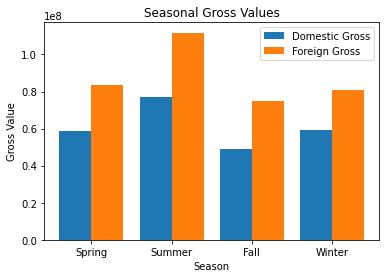

In [362]:
w=0.4
x = ['Spring', 'Summer', 'Fall', 'Winter']
domestic_gross_x = [5.868469e+07, 7.679157e+07, 4.878626e+07, 5.906062e+07]
foreign_gross = [8.363396e+07, 1.117212e+08, 7.503076e+07, 8.060080e+07]

bar1 = np.arange(len(x))
bar2 = [i+w for i in bar1]

plt.bar(bar1,domestic_gross_x,w,label='Domestic Gross')
plt.bar(bar2,foreign_gross,w,label='Foreign Gross')
plt.title('Seasonal Gross Values')
plt.xticks(bar1+w/2,x)
plt.xlabel('Season')
plt.ylabel('Gross Value')
plt.legend()
plt.show()

#### Hypothesis Testing

##### Hypothesis
    Null: There is no significant difference between the summer release dates and non summer release dates. H0:𝜇 ≥ 𝑥¯  
    Alternative: The the gross value is significantly bigger when released than not released in summer mean. 𝐻𝑎: 𝜇<𝑥¯
    Alpha= .02

**We will be performing a**  
<span style='color: red'>TODO</span>  
Finish this

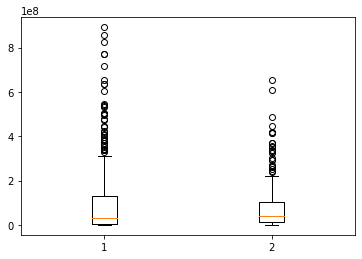

In [363]:
summer = movieGrossJoinBudgets['Season'].values == 2
forSummer = movieGrossJoinBudgets.loc[summer]['foreign_gross']
domSummer = movieGrossJoinBudgets.loc[summer]['domestic_gross_x']
plt.boxplot([forSummer, domSummer], );

In [364]:
winter = movieGrossJoinBudgets['Season'].values == 4
spring = movieGrossJoinBudgets['Season'].values == 1
fall = movieGrossJoinBudgets['Season'].values == 3

forSpring = movieGrossJoinBudgets.loc[spring]['foreign_gross']
domSpring = movieGrossJoinBudgets.loc[spring]['domestic_gross_x']
forFall = movieGrossJoinBudgets.loc[fall]['foreign_gross']
domFall = movieGrossJoinBudgets.loc[fall]['domestic_gross_x']
forWinter = movieGrossJoinBudgets.loc[winter]['foreign_gross']
domWinter = movieGrossJoinBudgets.loc[winter]['domestic_gross_x']

{'whiskers': [<matplotlib.lines.Line2D at 0x28b221101f0>,
 'caps': [<matplotlib.lines.Line2D at 0x28b25367790>,
 'boxes': [<matplotlib.lines.Line2D at 0x28b223cbeb0>,
 'medians': [<matplotlib.lines.Line2D at 0x28b253677c0>,
 'fliers': [<matplotlib.lines.Line2D at 0x28b2523ae20>,
 'means': []}

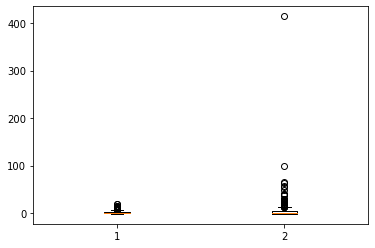

In [365]:
forSummer = forSummer[(forSummer>np.quantile(forSummer,0.25)) & (forSummer<np.quantile(forSummer,0.75))].tolist()

domSummer = domSummer[(domSummer>np.quantile(domSummer,0.25)) & (domSummer<np.quantile(domSummer,0.75))].tolist()

plt.boxplot([s1, s2], )

In [366]:
forSpring = forSpring[(forSpring>np.quantile(forSpring,0.25)) & (forSpring<np.quantile(forSpring,0.75))].tolist()

domSpring = domSpring[(domSpring>np.quantile(domSpring,0.25)) & (domSpring<np.quantile(domSpring,0.75))].tolist()

In [367]:
forFall = forFall[(forFall>np.quantile(forFall,0.25)) & (forFall<np.quantile(forFall,0.75))].tolist()

domFall = domFall[(domFall>np.quantile(domFall,0.25)) & (domFall<np.quantile(domFall,0.75))].tolist()

In [368]:
forWinter = forWinter[(forWinter>np.quantile(forWinter,0.25)) & (forWinter<np.quantile(forWinter,0.75))].tolist()

domWinter = domWinter[(domWinter>np.quantile(domWinter,0.25)) & (domWinter<np.quantile(domWinter,0.75))].tolist()

<span style="color: red;">TODO</span>  
Change 1 sample test to 2 sample test; divide p_val by 2 for 1-sample test; give explanation at beginning of section for hypothesis test approach

In [369]:
# T-test for foriegn market in summer
st.ttest_1samp(forSummer, popmean = movieGrossJoinBudgets['foreign_gross'].mean())

Ttest_1sampResult(statistic=-16.975658219619813, pvalue=1.0542502218032285e-37)

In [370]:
#T-test for domestic market for summer
st.ttest_1samp(domSummer, popmean = movieGrossJoinBudgets['domestic_gross_x'].mean())

Ttest_1sampResult(statistic=-9.362271608584594, pvalue=6.391346686277828e-17)

#  Decision

In [371]:
"""
Since pvalue both pvalue for foreign and domestic gross are less than an alpha = .02 we reject the null.
Stating that we are 98% sure that movies released in the Summer will result in larger gross profits.
"""

'\nSince pvalue both pvalue for foreign and domestic gross are less than an alpha = .02 we reject the null.\nStating that we are 98% sure that movies released in the Summer will result in larger gross profits.\n'

## ANOVA Test

<span style="color: red;">TODO</span>  
Explain test
Establish H0/HA and alpha = 0.02

In [372]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('foreign_gross ~ C(Season)', data=movieGrossJoinBudgets).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(Season),2.137147e+17,3.0,3.314961,0.019339
Residual,2.800137e+19,1303.0,NaN,NaN


In [373]:
model = ols('domestic_gross_x ~ C(Season)', data=movieGrossJoinBudgets).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(Season),1.133534e+17,3.0,5.303284,0.001235
Residual,9.283526e+18,1303.0,NaN,NaN


We conclude that there is a statistical difference between at least one pair of seasons. 

We will test summer against each season to see if it performs significantly better than each.

In [374]:
#summer vs spring: for
stat, pval = st.ttest_ind(forSummer,forSpring,equal_var = False)
pval/2

1.3961565172830544e-09

In [375]:
#summer vs fall: for
stat, pval =st.ttest_ind(forSummer,forFall,equal_var = False)
pval/2

9.209279835177572e-05

In [376]:
#summer vs winter: for
stat, pval =st.ttest_ind(forSummer,forWinter,equal_var = False)
pval/2

0.047716290774757

In [377]:
#summer vs spring: Dom
stat, pval =st.ttest_ind(domSummer,domSpring,equal_var = False)
pval/2

2.436180840113189e-10

In [378]:
#summer vs fall: dome
stat, pval =st.ttest_ind(domSummer,domFall,equal_var= False)
pval/2

3.9477440558149106e-13

In [379]:
#summer vs winter: dom
stat, pval =st.ttest_ind(domSummer,domWinter,equal_var = False)
pval/2

0.0020624802234053045

<span style="color: red;">TODO</span>  
Rephrase since using one-tailed tests

Given alpha=0.02:
* We found a significant difference between summer and all other seasons for the domestic market.
* We found a significant difference between summer with fall and winter for the foreign market.
* We did not find a significant difference between summer and spring in the foreign market.

<span style='color: red'>TODO</span>  
Alex W.:  
Add conclusion  
Make explicit business suggestions and actionable insights